### 1. Data Loading

In this part, data importing is performed along with downcasting of columns to save some space in memory. We are going to use the flight data of year of 2018. All other miscellaneous data can be found under ~/data/misc folder.

In [1]:
# load necessary libraries
%matplotlib inline
import os
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','flight_delay'))
import datetime
import holidays
import pandas as pd
import numpy as np
import progressbar
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from utils import df_par # for parallelization

In [2]:
data_dir = os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','data','flight_data')
misc_data_dir = os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','data','misc')
# Before importing data, let's define datatypes of columns
types = {0: 'int8', 1: 'category', 2: 'category', 3: 'int16', 4: 'int16', 5: 'int32',
         6: 'int16', 7: 'int32', 18: 'bool', 19: 'int8', 20: 'bool', 24: 'int16',
         25: 'int16', 26: 'int16', 27: 'int16', 28: 'int16', 29: 'int16', 31: 'float32',
         32: 'float32', 33: 'float32', 34: 'float32', 35: 'float32', 36: 'float32', 
         37: 'float32', 38: 'float32', 39: 'float32', 40: 'float32', 41: 'float32', 
         42: 'float32', 43: 'float32', 44: 'float32'}
# Now, import the data
flights = pd.read_csv(os.path.join(data_dir,'2018_final.csv'), usecols=range(0,45), dtype=types, parse_dates=[8, 9, 12, 13, 15, 16])
# Load airline codes and name
airlines = pd.read_csv(os.path.join(misc_data_dir,'airline.csv'), usecols=[1,3])
airlines = airlines.drop_duplicates(subset='CARRIER', keep='last')
airlines.columns = ['Code', 'CarrierName']
# Load airport data
airport = pd.read_csv(os.path.join(misc_data_dir,'airport.csv'), usecols = [0, 1, 2, 3, 4, 5, 6, 11, 16, 17])
airport.columns = ['AirID', 'Code', 'Name', 'City', 'Country', 'State', 'CityMarketID', 'Lat', 'Long', 'UTC']
airport = airport.drop_duplicates(subset='AirID', keep='last')

In [3]:
# Now, we need assign timedelta type to the columns listed below (in parallel)
cols = ['DepDelay', 'TxO', 'TxI', 'ArrDelay', 'ScElaTime', 'AcElaTime', 'AirTime', 'TimeZoneDiff']
for name in cols:
    flights.loc[:, name] = df_par(flights.loc[:, name], pd.to_timedelta)
flights.DepTime = flights.ScDepTime + flights.DepDelay

In [4]:
flights.head()

WeekDay IATA TailNum  FlightNum  OrgAirID  OrgMarID  DestAirID  DestMarID  \
0        1   AA  N156UW        430     14771     32457      11057      31057   
1        1   DL  N669DN        806     14771     32457      13487      31650   
2        1   UA  N14240       1104     10299     30299      11292      30325   
3        1   AS  N530AS        174     10299     30299      12889      32211   
4        1   UA  N66808       2393     14747     30559      12266      31453   

            ScDepTime             DepTime  ...  Dir_O WindSp_O Visib_O  \
0 2018-01-01 00:20:00 2018-01-01 00:14:00  ...  200.0     3.45     8.0   
1 2018-01-01 00:20:00 2018-01-01 00:14:00  ...  200.0     3.45     8.0   
2 2018-01-01 00:25:00 2018-01-01 00:12:00  ...  350.0    10.35    10.0   
3 2018-01-01 00:25:00 2018-01-01 00:12:00  ...  350.0    10.35    10.0   
4 2018-01-01 00:27:00 2018-01-01 00:15:00  ...   10.0    14.95    10.0   

      Temp_D DewPoint_D   RelHum_D  HeatInd_D  Dir_D  WindSp_D  Visib_D  
0  25.000000       -6.0  24.889999  16.250000   20.0      8.05     10.0  
1 -11.000000      -17.0  73.940002 -29.950001  300.0     10.35     10.0  
2   8.100000        3.9  82.580002  -4.350000  150.0      8.05      8.0  
3  46.900002       12.0  24.030001  44.090000  220.0      5.75     10.0  
4  37.900002       28.9  69.730003  29.920000   20.0     12.65     10.0  

[5 rows x 45 columns]

### 2. Exploratory Data Analysis
In this section, I will investigate the data to get meaningful insights, relations between flight delays and several other factors. This could be statistical correlation or patterns.

In [5]:
# Create a deep copy
temp = flights.copy()
# Set departure delay values of early departed flights to zero
temp.loc[temp.loc[:, 'DepDelay'] < np.timedelta64(0,'m'), 'DepDelay'] = np.timedelta64(0,'m')

#### 2.1. Busiest Airlines and Airports

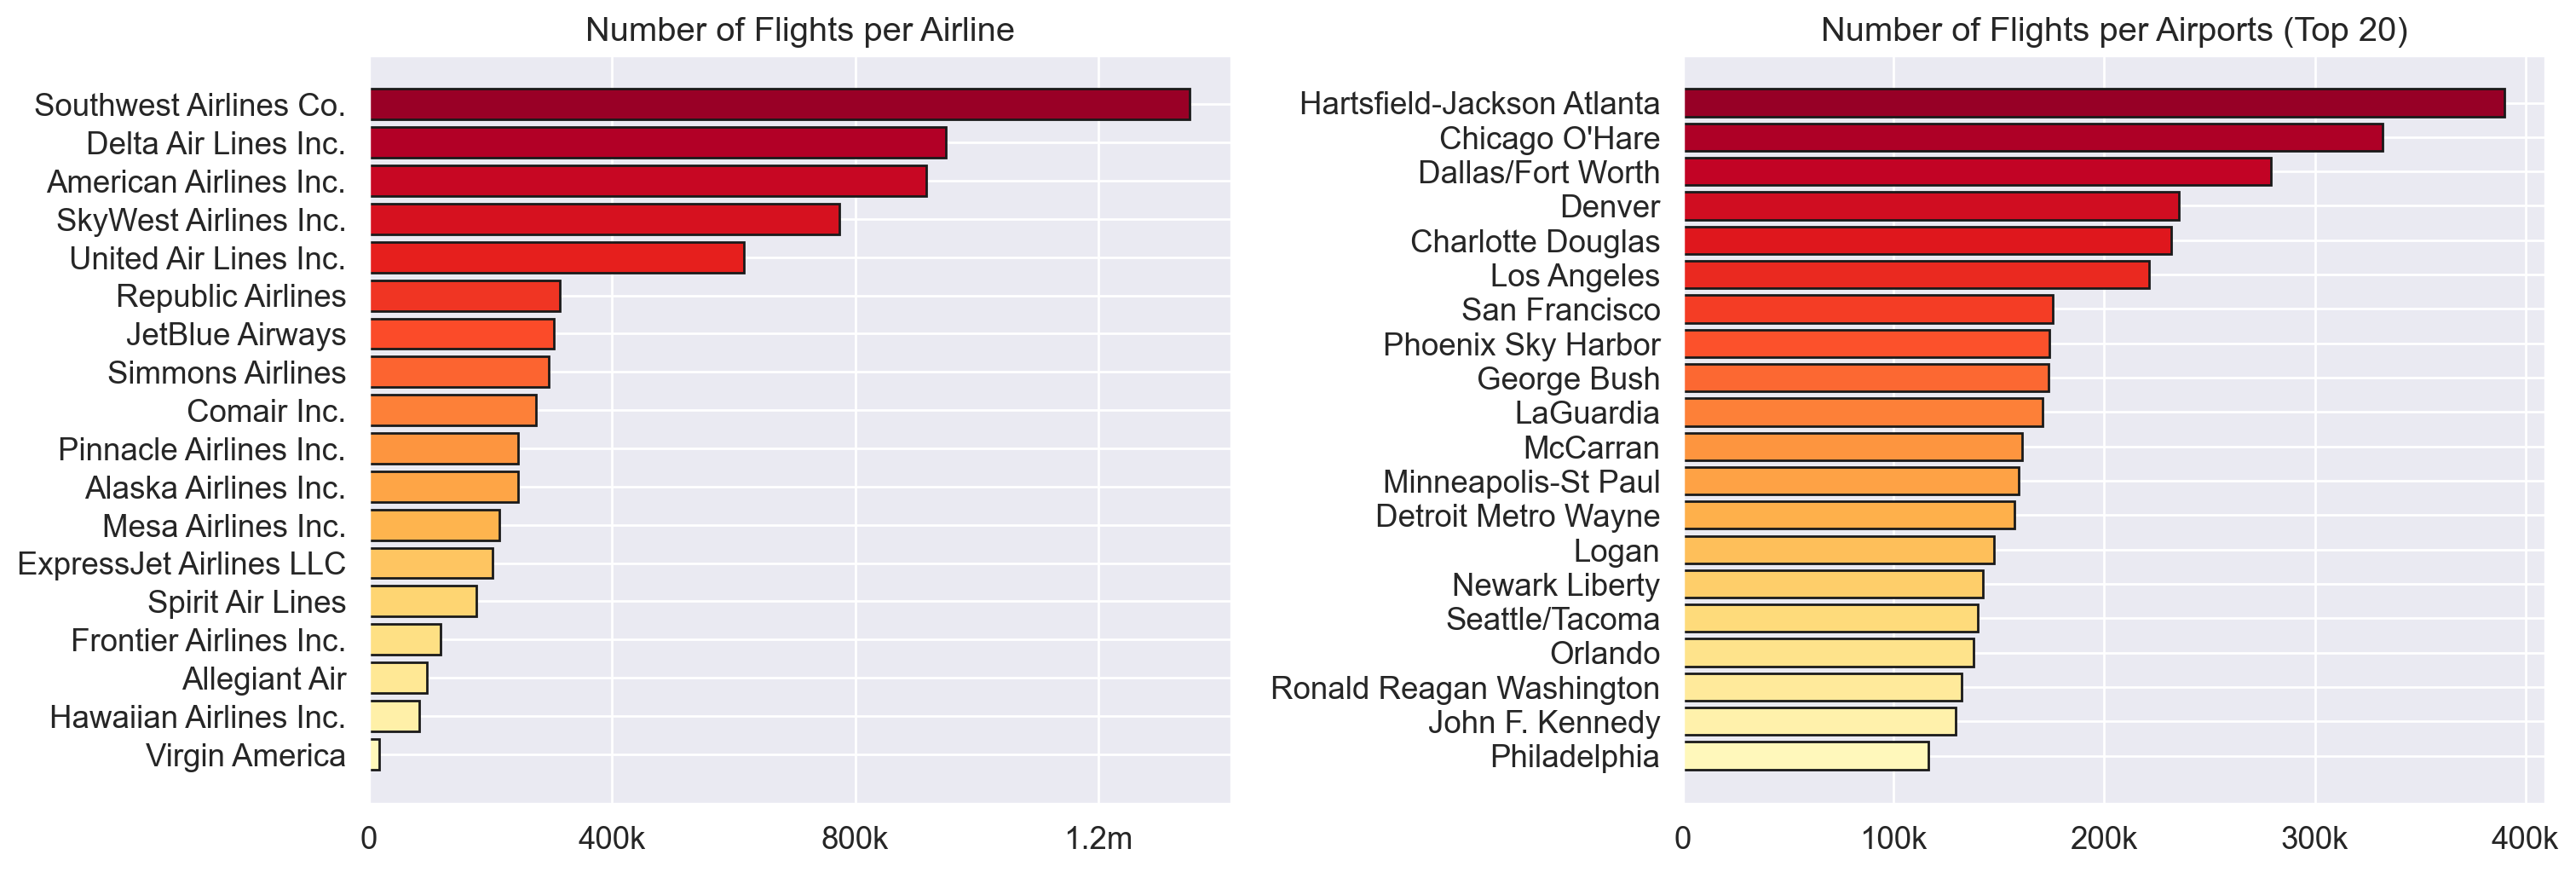

In [6]:
# Big figure
fig = plt.figure(figsize=(15,5), constrained_layout=True, dpi=200)
# Set font size
sns.set(font_scale=1.2)
# Arrange grid size of subplot
grid = plt.GridSpec(1, 2, hspace=0.1, wspace=0.1, figure=fig)
ax1 = plt.subplot(grid[0])
ax2 = plt.subplot(grid[1])
# Merge two dataframe for busiest airlines
temp_df = pd.merge(temp.IATA.value_counts(), airlines, left_index=True, right_on='Code').sort_values('IATA')
# Set color
colors= sns.color_palette('YlOrRd', 18)
# Top Airlines
ax1.barh(temp_df.CarrierName, temp_df.IATA, color=colors, edgecolor='k')
# Axis arrangements
ax1.set_xticks([x * 1e6 for x in [0, 0.4, 0.8, 1.2]])
ax1.set_xticklabels(['0', '400k', '800k', '1.2m'])
ax1.set_title('Number of Flights per Airline')
# Reset color cycle
plt.gca().set_prop_cycle(None)
colors = sns.color_palette('YlOrRd', 20)
# Merge two dataframe for busiest airports
temp_df = pd.merge(temp.OrgAirID.value_counts().head(20), airport, left_index=True, right_on='AirID').sort_values('OrgAirID')
# Top Airports
ax2.barh(temp_df.Name.str.rsplit(' ',1).str[0], temp_df.OrgAirID, color=colors, edgecolor='k')
# Axis arrangements
ax2.set_xticks([x * 1e5 for x in [0, 1, 2, 3, 4]])
ax2.set_xticklabels(['0', '100k', '200k', '300k', '400k'])
_ = ax2.set_title('Number of Flights per Airports (Top 20)') # Disable ouput

# Delete temporary variables
del grid, ax1, ax2, temp_df, colors

#### 2.2. Airline On-Time Performance (General)

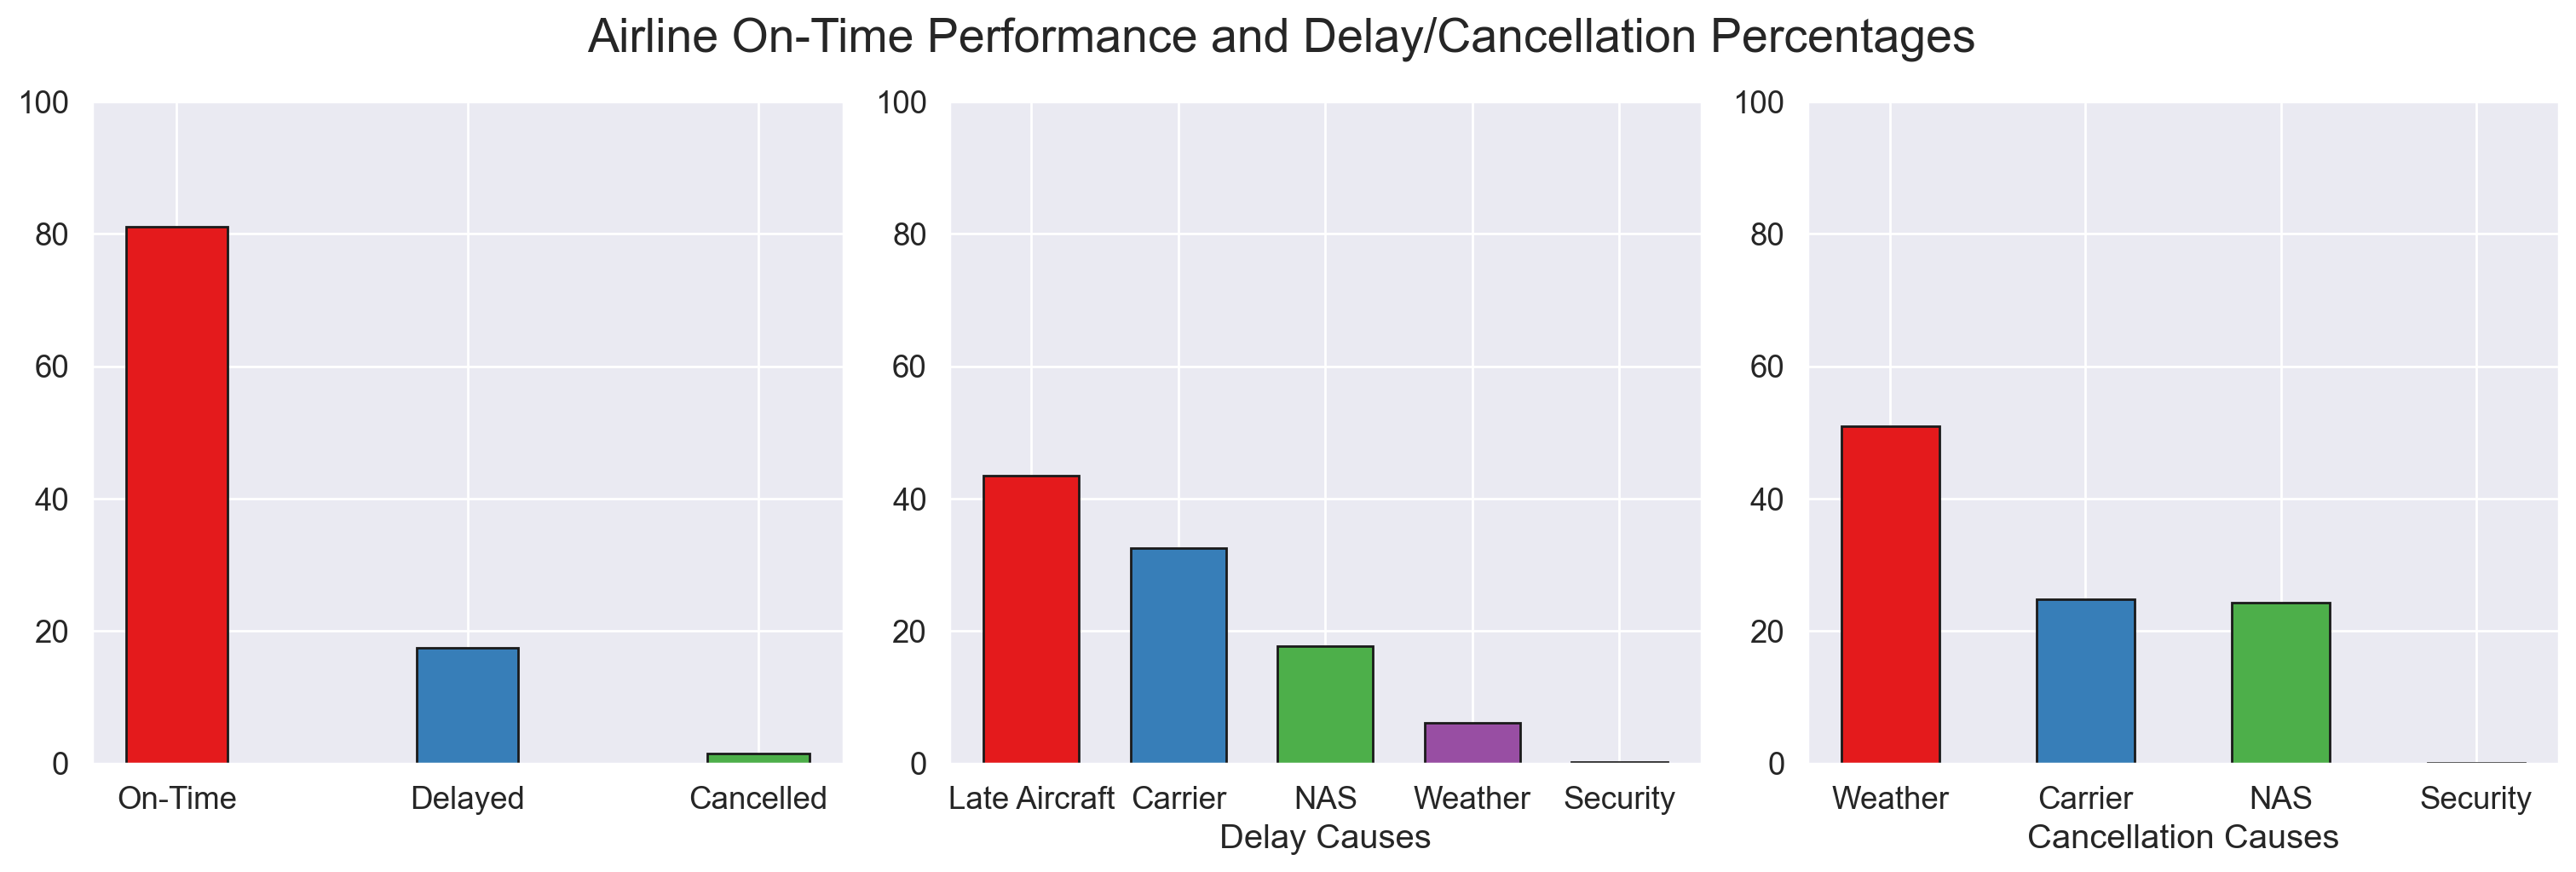

In [7]:
# Big figure
fig = plt.figure(figsize=(15,5), constrained_layout=True, dpi=200)
# Set font size
sns.set(font_scale=1.2)
# Arrange grid size of subplot
grid = plt.GridSpec(1, 3, hspace=0.1, wspace=0.1, figure=fig)
ax1 = plt.subplot(grid[0])
ax2 = plt.subplot(grid[1])
ax3 = plt.subplot(grid[2])
# Prepare data
d = {'On-Time': (temp.DepDelay <= np.timedelta64(15, 'm')).sum(), 
     'Delayed': (temp.DepDelay > np.timedelta64(15, 'm')).sum(), 
     'Cancelled': temp.Cncl.sum()}
temp_df = pd.Series(d, index=['On-Time','Delayed','Cancelled'])
temp_df = temp_df / temp_df.sum()
# Plot airline performance percentage
colors= sns.color_palette('Set1',4)
ax1.bar(temp_df.index, temp_df.values * 100, width=0.35, color=colors, edgecolor='k')
ax1.set_ylim([0, 100])

# Prepare data
temp_df = temp[temp.DepDelay > np.timedelta64(15, 'm')].iloc[:, [25, 26, 27, 28, 29]]
temp_df = temp_df.sum(axis=0).sort_values(ascending=False) / temp_df.sum().sum()
temp_df = temp_df.rename(index={'CarrDel': 'Carrier', 'WeaDel': 'Weather', 'NASDel': 'NAS', 
                                'SecDel': 'Security', 'LatAirDel': 'Late Aircraft'})
# Plot delay percentage
ax2.bar(temp_df.index, temp_df.values * 100, width=0.65, color=colors, edgecolor='k')
ax2.set_ylim([0, 100])
ax2.set_xlabel('Delay Causes')

# Prepare data
temp_df = temp[temp.Cncl == 1].loc[:, 'CnclCd'].value_counts()[:-1]
temp_df = temp_df.sort_values(ascending=False) / temp_df.sum()
temp_df = temp_df.rename(index={1: 'Carrier', 2: 'Weather', 3: 'NAS', 4: 'Security'})
# Plot cancellation percentage
ax3.bar(temp_df.index, temp_df.values * 100, width=0.5, color=colors, edgecolor='k')
ax3.set_ylim([0, 100])
ax3.set_xlabel('Cancellation Causes')
# Add title
_ = fig.suptitle('Airline On-Time Performance and Delay/Cancellation Percentages ', fontsize=20) # Disable ouput

# Delete temporary variables
del grid, ax1, ax2, ax3, temp_df, colors

There are several causes for a flight to be delayed. It is interesting to look at the proportions or chances of encountering certain delay type. Almost 20% of the fights tend to be late (this taking account delays more than 15 mins). Most planes are late due to late aircraft and/or airline delays. This is interesting because it means that it is an area of the airline industry that could be optimized. Supporting our argument, one notices that the lower amount of delays are caused due to weather and security issues. Showing us that security for example is optimized to a very large level and other types of delays could eventually be avoided by optimizing organization in airports or establishing a delay prevention schedule. Weather delays are rather rare and are not primary reasons for flights to be delayed.

#### 2.3. Airline On-Time Performance per Airline Companies and Airports

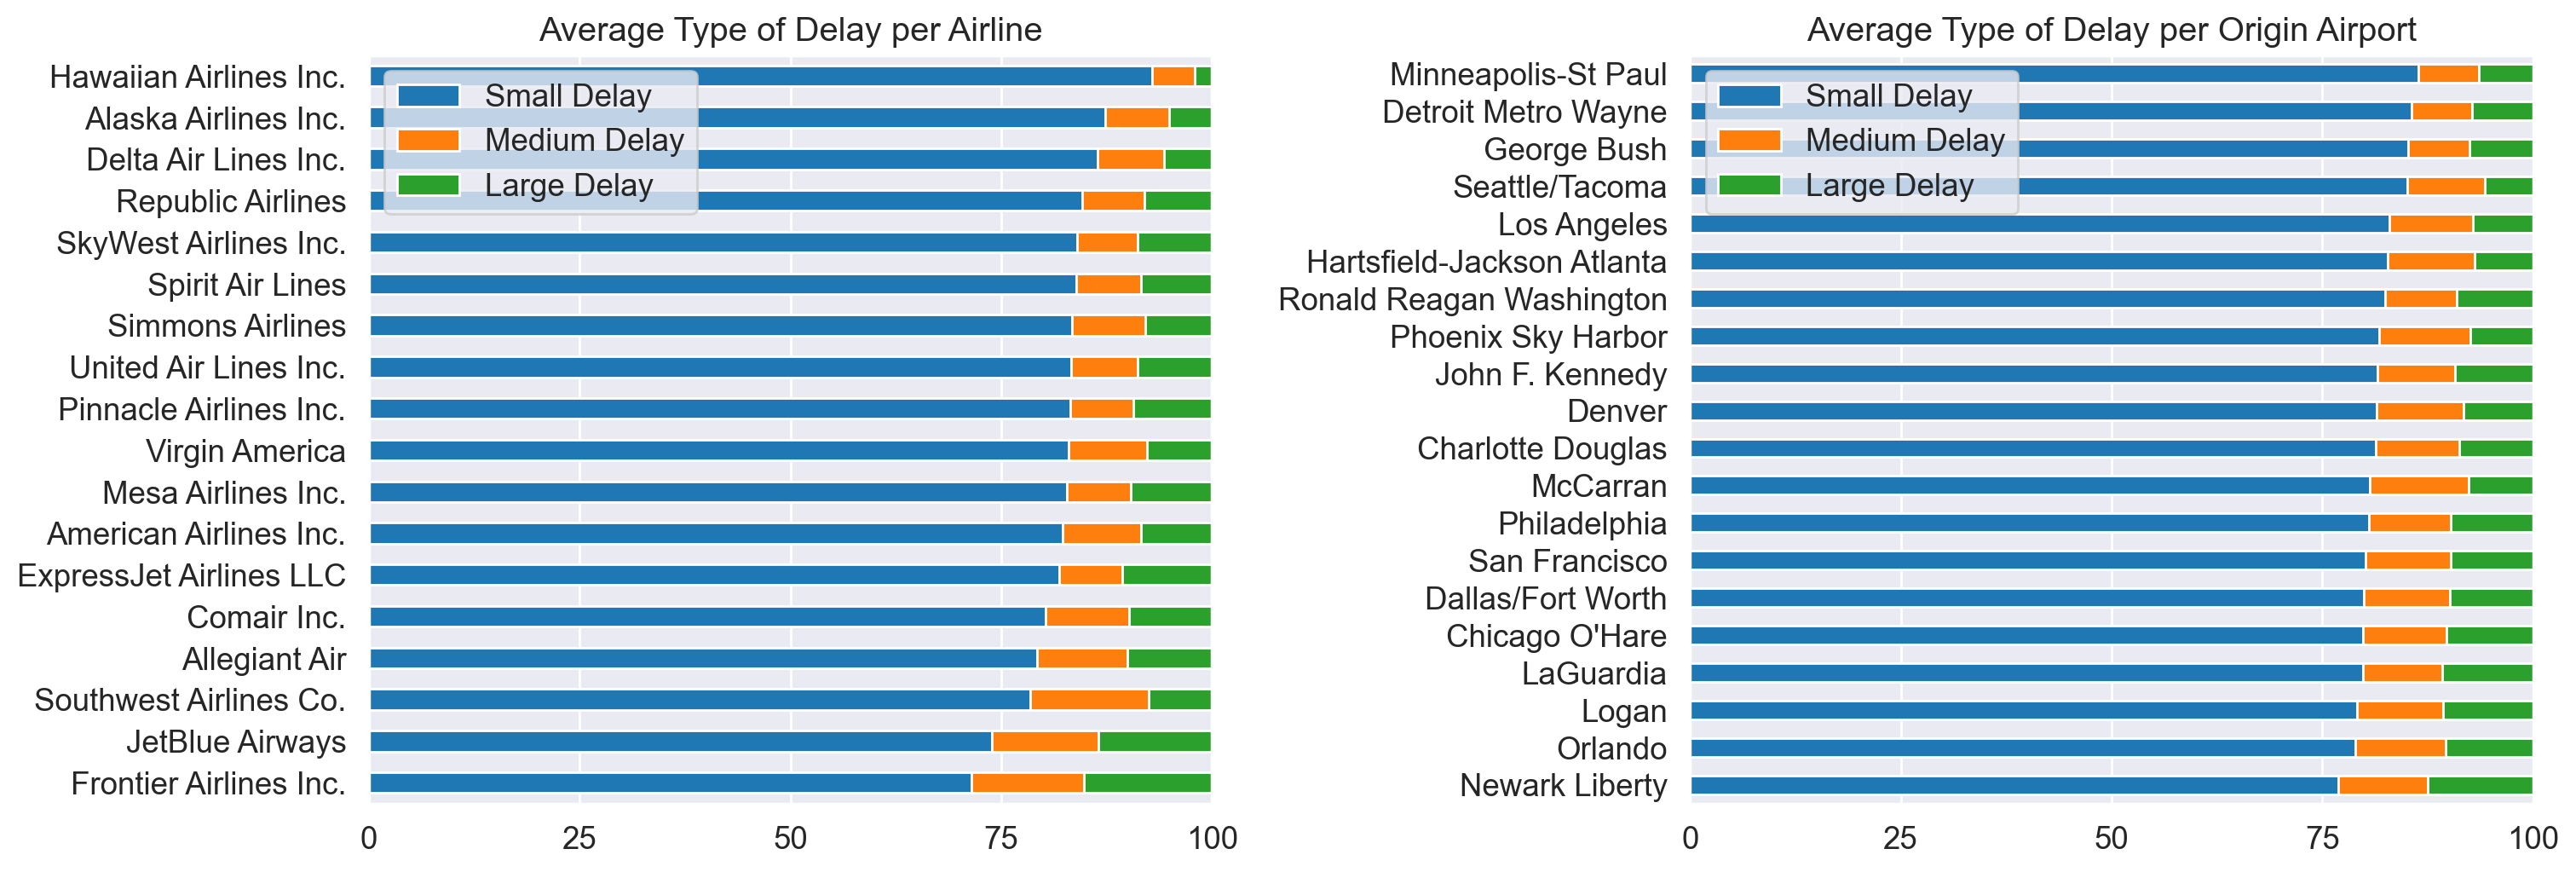

In [8]:
# Big figure
fig = plt.figure(figsize=(15,5), constrained_layout=True, dpi=200)
# Set font size
sns.set(font_scale=1.2)
# Arrange grid size of subplot
grid = plt.GridSpec(1, 2, hspace=0.1, wspace=0.1, figure=fig)
ax1 = plt.subplot(grid[0])
ax2 = plt.subplot(grid[1])
# Remove cancelled flights
temp_df = temp.loc[temp.DepDelay.notna()]
# Set criteria for small, medium, and large delay
a = datetime.timedelta(minutes=15)
b = datetime.timedelta(minutes=45)
# Small delay (less than 15 mins)
sm = temp_df.groupby('IATA').apply(lambda x: (x.DepDelay <= a).sum()).rename('Small Delay')
# Medium delay (more than 15 mins and less than 45 mins)
md = temp_df.groupby('IATA').apply(lambda x: ((x.DepDelay > a) & (x.DepDelay <= b)).sum()).rename('Medium Delay')
# Large delay (more than 45 mins)
lr = temp_df.groupby('IATA').apply(lambda x: (x.DepDelay > b).sum()).rename('Large Delay')
# Concatenate
t = pd.concat([sm, md, lr], axis=1)
# Normalize
t = t.div(t.sum(axis=1), axis=0)
# Merge with airline data to get company names
t = pd.merge(t, airlines, left_index=True, right_on='Code').iloc[:, [0,1,2,-1]].set_index('CarrierName')
# Sort by small delay
t = t.sort_values('Small Delay', ascending=True)
# Set colors for 18 airline companies
colors= sns.color_palette('tab10', 18)
# Stacked Bar Plot
t.plot(kind='barh', stacked=True, ax=ax1, color=colors, xticks=[0, 0.25, 0.5, 0.75, 1])
# Axis arrangements
ax1.set_xlim([0, 1])
ax1.set_xticklabels(['0', '25', '50', '75', '100'])
ax1.set_ylabel('')
ax1.set_title('Average Type of Delay per Airline')
ax1.legend(loc='upper left')

# Take only top 20 airport data
temp_df = temp[temp.OrgAirID.isin(temp.OrgAirID.value_counts().head(20).index)]
# Small delay (less than 15 mins)
sm = temp_df.groupby('OrgAirID').apply(lambda x: (x.DepDelay <= a).sum()).rename('Small Delay')
# Medium delay (more than 15 mins and less than 45 mins)
md = temp_df.groupby('OrgAirID').apply(lambda x: ((x.DepDelay > a) & (x.DepDelay <= b)).sum()).rename('Medium Delay')
# Large delay (more than 45 mins)
lr = temp_df.groupby('OrgAirID').apply(lambda x: (x.DepDelay > b).sum()).rename('Large Delay')
# Concatenate
t = pd.concat([sm, md, lr], axis=1)
# Normalize
t = t.div(t.sum(axis=1), axis=0)
# Merge with airline data to get airport names
t = pd.merge(t, airport.loc[:,['AirID','Name']], left_index=True, right_on='AirID').iloc[:,[0,1,2,-1]]
# Remove 'International' from airport names
t.loc[:, 'Name'] = t.Name.str.rsplit(' ',1).str[0]
# Set index
t.set_index('Name', inplace=True)
# Sort by small delay
t = t.sort_values('Small Delay', ascending=True)
# Set colors for top 20 airports
colors= sns.color_palette('tab10', 20)
# Stacked Bar Plot
t.plot(kind='barh', stacked=True, ax=ax2, color=colors, xticks=[0, 0.25, 0.5, 0.75, 1])
# Axis arrangements
ax2.set_xlim([0, 1])
ax2.set_xticklabels(['0', '25', '50', '75', '100'])
ax2.set_ylabel('')
ax2.set_title('Average Type of Delay per Origin Airport')
_ = ax2.legend(loc='upper left') # Disable output

# Delete temporary variables
del grid, ax1, ax2, temp_df, a, b, sm, md, lr, t, colors

Delays are divided into three categories, namely "on time or small delay" (up to 15 minutes delay), "Medium delay" (15 – 45 minutes delay) and "Large delay" (45 minutes delay). In this way the graphic representation is more understandable as well as the possibility of directly comparing the variables related with delays. As represented one can observe that Airlines that were particularly good at being on time compared to other airlines were Hawaiian Airlines, Alaska Airlines, and Delta Airlines. Those that tend to have a larger delay are Frontier Airlines, JetBlue Airways, and Southwest Airlines.

The same type of analysis can be one for different airports. In this case one can observe that airports such as Minneapolis and Detroit stand out positively, while the one with the worst frequency of delays is Newark. However, the differences are less obvious and, generally speaking, one can conclude that airlines play a more significant role than the airports of departure.

#### 2.4. Effect of departure time and week days of a flight on departure delay

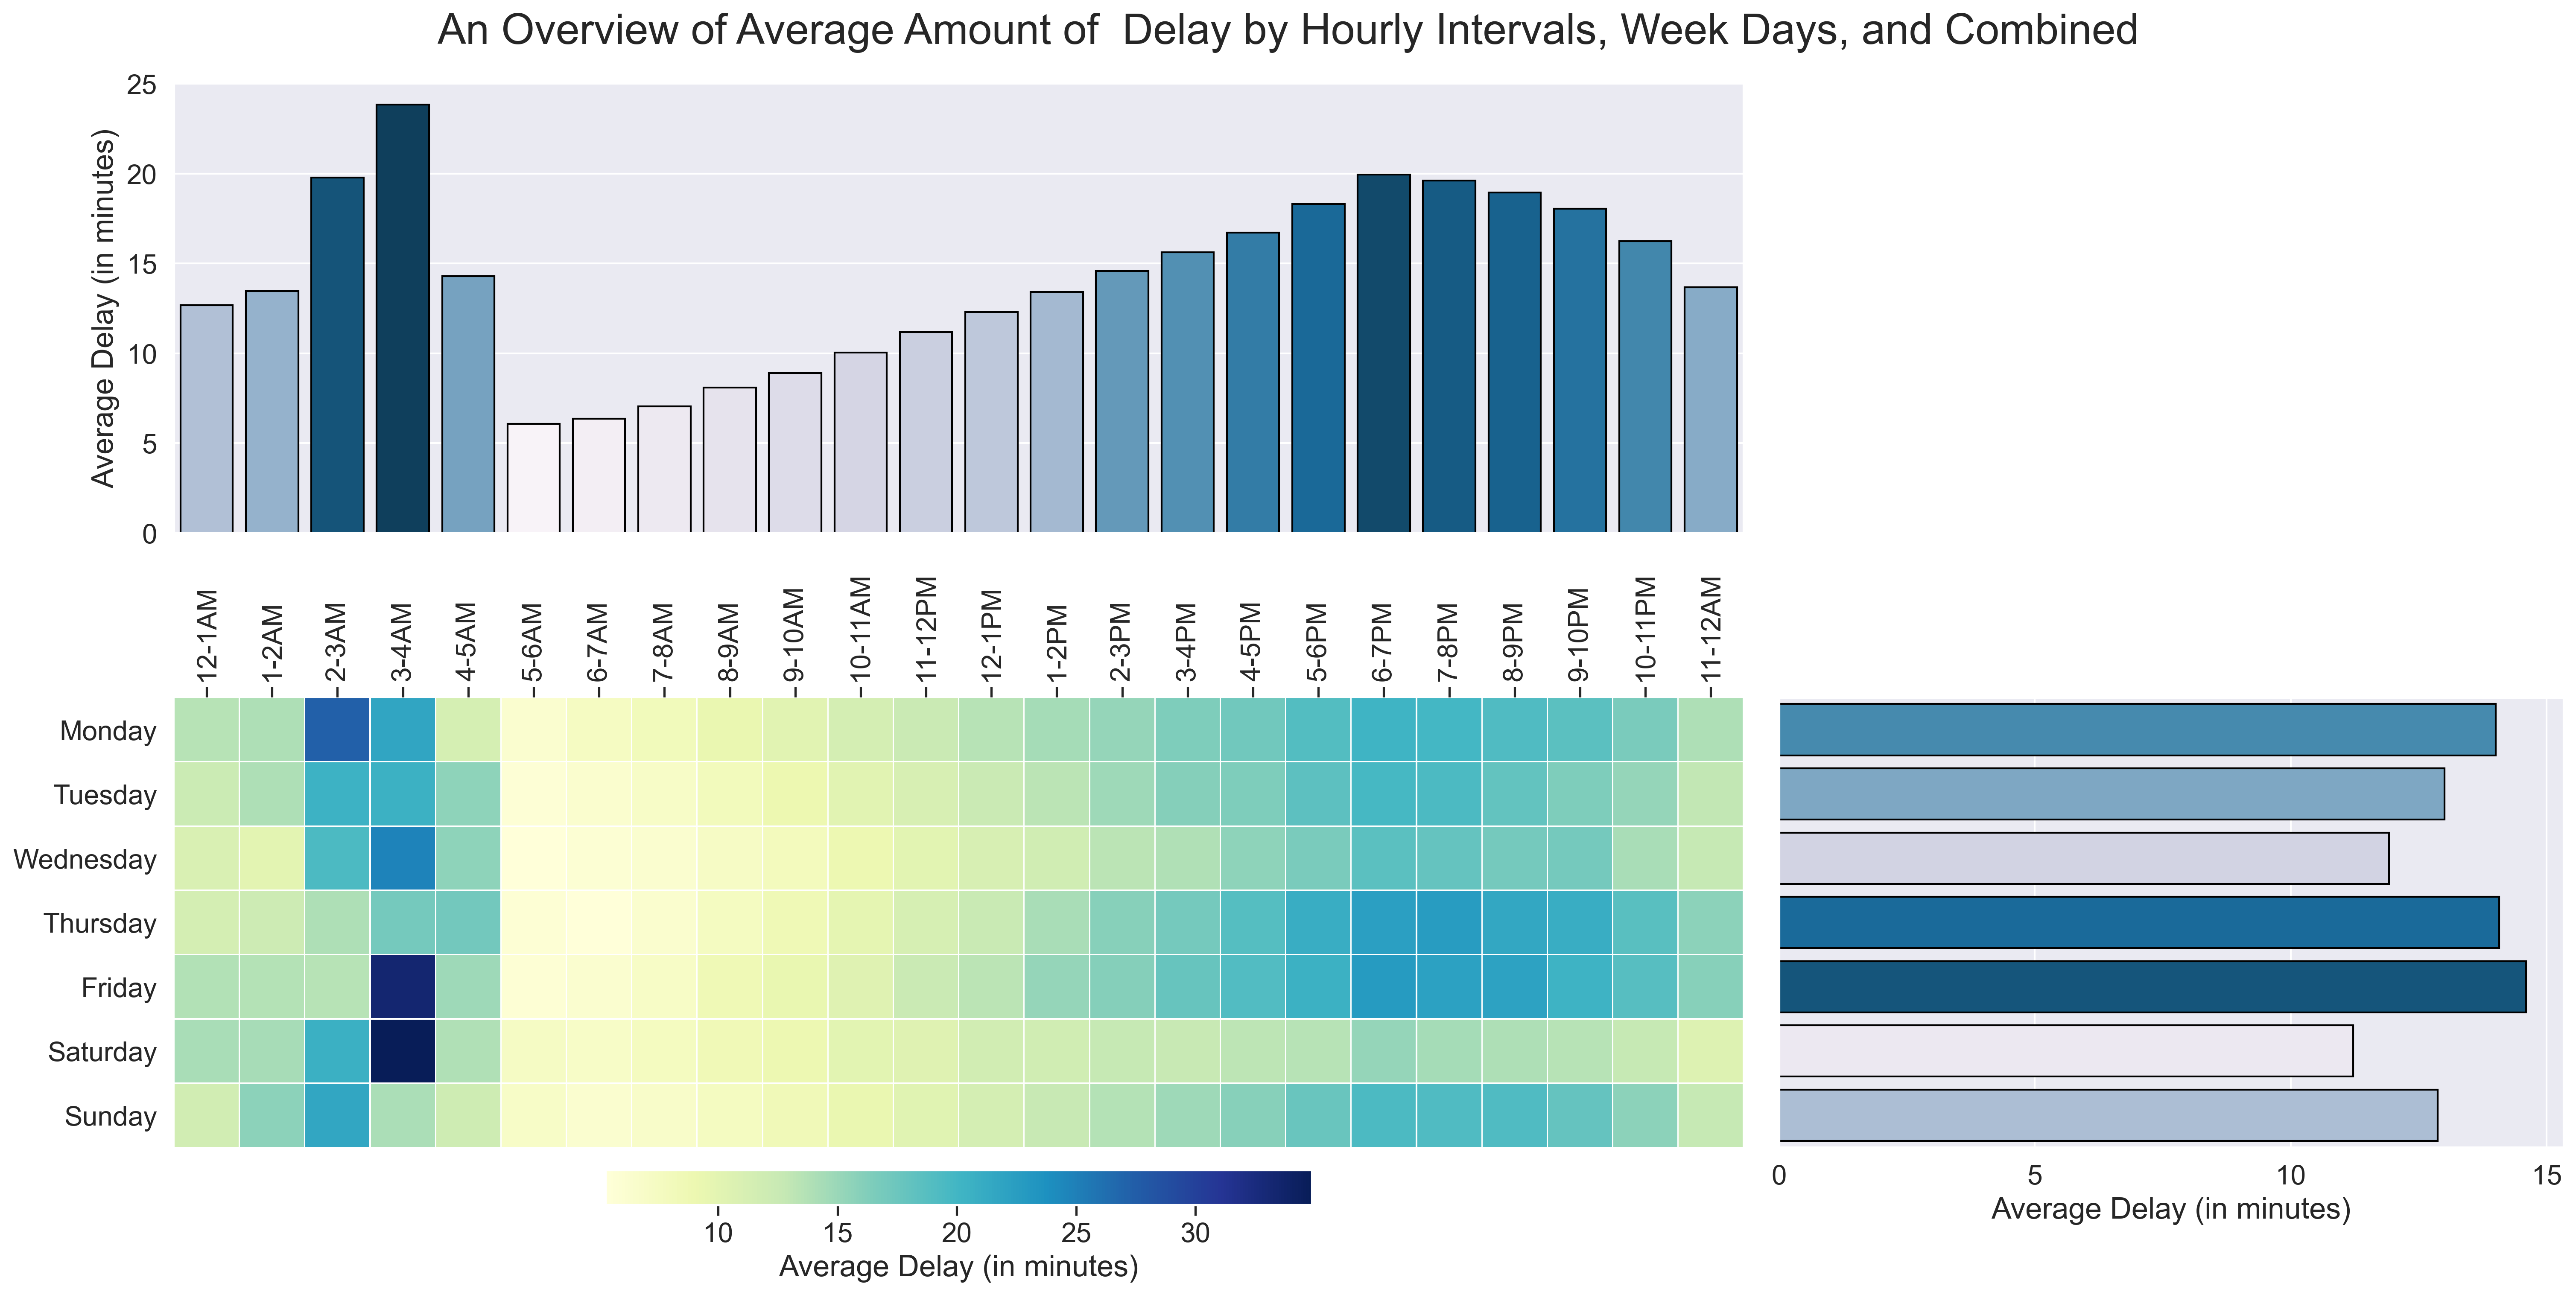

In [9]:
# Group by WeekDay and scheduled departure hour
heat_map = temp.groupby([temp.WeekDay, temp.ScDepTime.dt.hour])['DepDelay'].apply(lambda x: np.mean(x)).unstack()
# Convert it to the float
heat_map = heat_map.astype('timedelta64[s]') / 60
# Big figure
fig = plt.figure(figsize=(20,10), constrained_layout=True, dpi=300)
# Set font size
sns.set(font_scale=1.4)
# Arrange grid size of subplot
grid = plt.GridSpec(2, 3, hspace=0.2, wspace=0.1, figure=fig)
ax_hr = plt.subplot(grid[0, :-1])
ax_heat = plt.subplot(grid[1, :-1])
ax_week = plt.subplot(grid[1, -1])
# Plot heatmap
hm = sns.heatmap(heat_map, square=False, linewidths=.5, cmap="YlGnBu", cbar=False, ax = ax_heat,
                 yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                 xticklabels=['12-1AM', '1-2AM', '2-3AM', '3-4AM', '4-5AM', '5-6AM', '6-7AM', '7-8AM', '8-9AM',
                             '9-10AM', '10-11AM', '11-12PM', '12-1PM', '1-2PM', '2-3PM', '3-4PM', '4-5PM', '5-6PM',
                             '6-7PM', '7-8PM', '8-9PM', '9-10PM', '10-11PM', '11-12AM'])
ax_heat.xaxis.set_ticks_position('top')
ax_heat.set_xticklabels(ax_heat.get_xticklabels(), rotation=90)
ax_heat.set_ylabel('')    
ax_heat.set_xlabel('')
# Group by scheduled departure hour
hist_hr = temp.groupby([temp.ScDepTime.dt.hour])['DepDelay'].apply(lambda x: np.mean(x))
# Convert it to the float
hist_hr = hist_hr.astype('timedelta64[s]') / 60
hist_hr = hist_hr.reset_index()
# Plot distribution
rank = hist_hr.DepDelay.argsort().argsort() # color sorting in palette
sns.barplot(x='ScDepTime', y='DepDelay', data=hist_hr, ax=ax_hr, 
            palette=np.array(sns.color_palette('PuBu', 24))[rank], edgecolor=(0,0,0))
ax_hr.set(xticklabels=[])
ax_hr.set(xlim=(-.5, 23.5))
ax_hr.set_ylabel('Average Delay (in minutes)')    
ax_hr.set_xlabel('')
# Group by week day
hist_wk = temp.groupby([temp.WeekDay])['DepDelay'].apply(lambda x: np.mean(x))
# Convert it to the float
hist_wk = hist_wk.astype('timedelta64[s]') / 60
hist_wk = hist_wk.reset_index()
# Plot distribution
rank = hist_wk.DepDelay.argsort().argsort() # color sorting in palette
sns.barplot(x='DepDelay', y='WeekDay', data=hist_wk, ax=ax_week, orient='h', 
            palette=np.array(sns.color_palette('PuBu', 7))[rank], edgecolor=(0,0,0))
ax_week.set(yticklabels=[])
ax_week.set_xticks([0, 5, 10, 15])
ax_week.set(xticklabels=['0', '5', '10', '15'])
ax_week.set(ylim=(6.5, -0.5))
ax_week.set_ylabel('')
ax_week.set_xlabel('Average Delay (in minutes)')
# Add title
fig.suptitle('An Overview of Average Amount of  Delay by Hourly Intervals, Week Days, and Combined', fontsize=24)
# Add colorbar
_ = fig.colorbar(hm.collections[0], ax=ax_heat, orientation='horizontal', shrink=0.45, 
                 aspect=10, label='Average Delay (in minutes)') # Disable output
# Delete temporary variables
del heat_map, grid, ax_hr, ax_heat, ax_week, hm, hist_hr, rank

The figure above summarizes average amount of delay in minutes by daily, hourly, and combined time intervals. One can realize that the two histograms around the heat map represent average delay with respect to daily (on the right) and hourly (on the top) axes. 

**From hourly interval perspective**, 

- delays are higher between 2:00 AM - 4:00 AM,
- early morning flights have less probability to be delayed (5:00 AM - 10:00 AM),
- probability of delay constantly increases between 5:00 AM and 7:00 PM,
- its relative peak is at between 6:00 PM - 7:00 PM.

**From daily interval perspective**,

- average amount of delay per day are so close to each other,
- the minimum delay happens on Saturdays,
- Saturdays happen to have minimum delays in evening flights,
- Thursdays and Fridays seem to have higher chance of having delay.

#### 2.5. Trends by Quarters

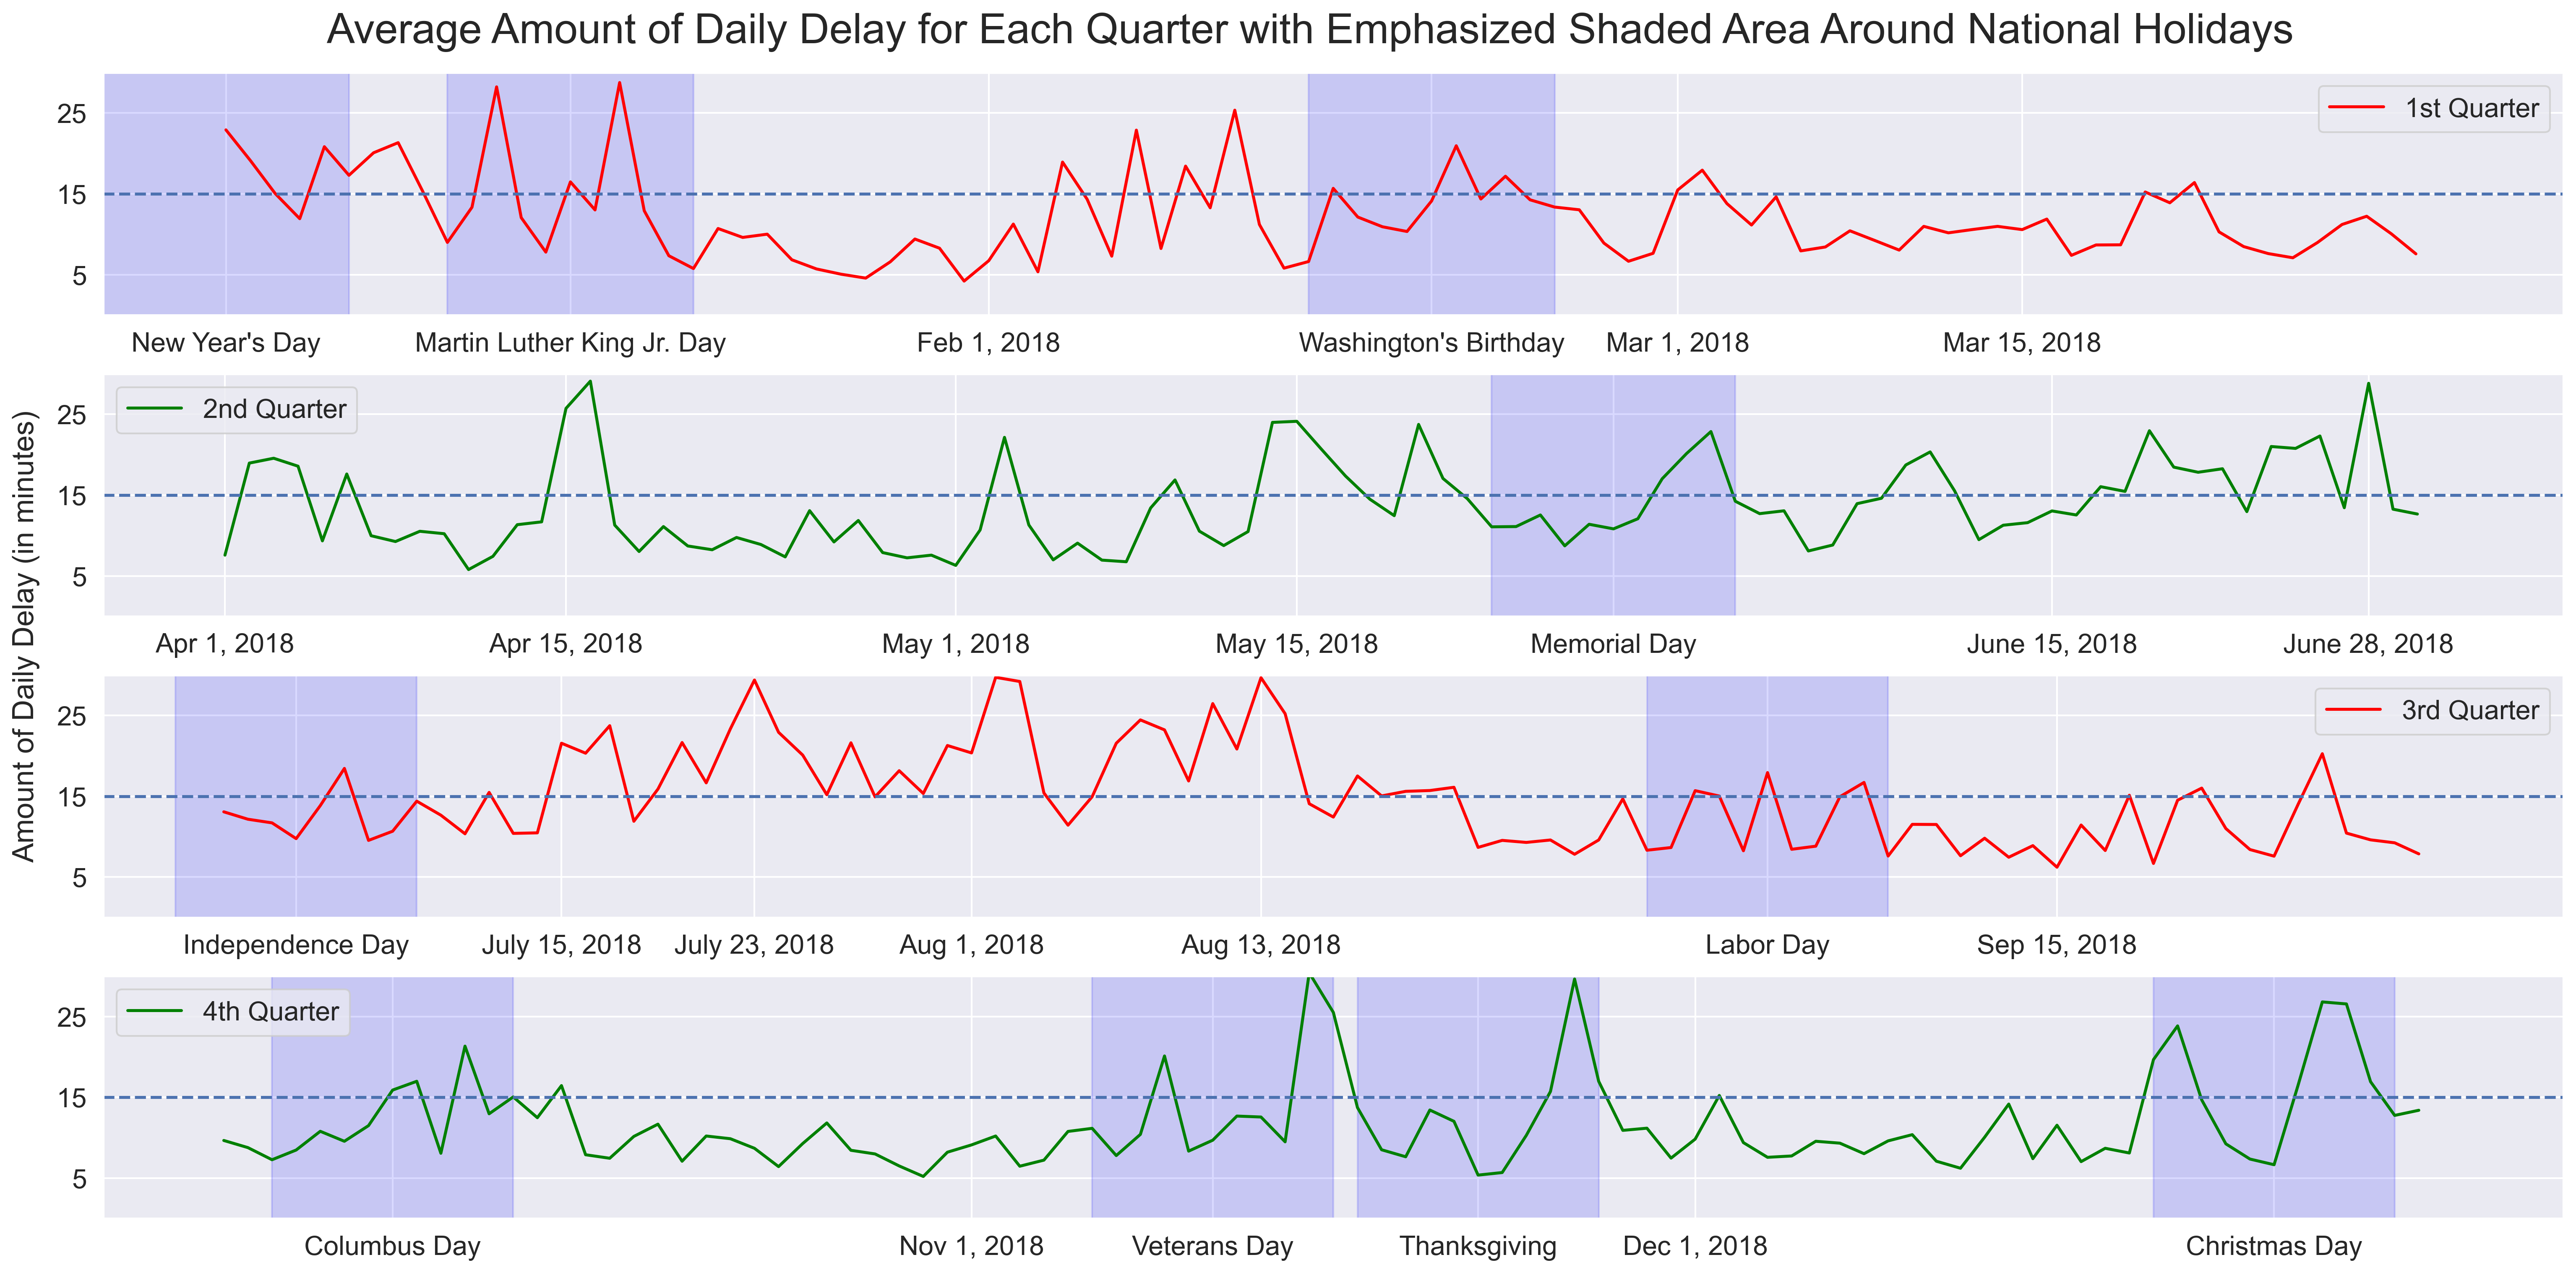

In [10]:
# US Federal Holidays
hld = holidays.US(years=2018, observed=False)
# Divide by meteorological seasons
first = temp[temp.ScDepTime.dt.month.isin([1,2,3])]
second = temp[temp.ScDepTime.dt.month.isin([4,5,6])]
third = temp[temp.ScDepTime.dt.month.isin([7,8,9])]
fourth = temp[temp.ScDepTime.dt.month.isin([10,11,12])]
# Set Subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20,10), constrained_layout=True, dpi=300)
sns.set(font_scale=1.4, rc={'lines.linewidth': 1.7})
# Offset for shaded area
offset = datetime.timedelta(days=5)
trans = 0.15
# Daily mean
t = first.groupby(first.ScDepTime.dt.date)['DepDelay'].apply(lambda x: np.mean(x)).astype('timedelta64[s]') / 60
# Plot (1st quarter)
sns.lineplot(data=t, ax=axs[0], ci=None, color='red', label='1st Quarter')
# Axis arrangement
axs[0].set_xlim(first.ScDepTime.min()-offset, first.ScDepTime.max()+offset)
axs[0].set_ylim(0, 30)
axs[0].set_yticks([5, 15, 25])
# Holidays in the first quarter
h_dict = {key: hld[key] for key in hld[first.ScDepTime.min():first.ScDepTime.max()]}
# Shaded area
for key, _ in h_dict.items(): 
    axs[0].axvspan(key-offset, key+offset, alpha=trans, color='blue')
# Dictionary update with regular dates
h_dict.update({datetime.date(2018,2,1): 'Feb 1, 2018', datetime.date(2018,3,1): 'Mar 1, 2018', 
           datetime.date(2018,3,15): 'Mar 15, 2018'})
# Set xticks and labels
axs[0].set_xticks(list(h_dict.keys()))
axs[0].set_xticklabels(list(h_dict.values()))

# Daily mean
t = second.groupby(second.ScDepTime.dt.date)['DepDelay'].apply(lambda x: np.mean(x)).astype('timedelta64[s]') / 60
# Plot (2nd quarter)
sns.lineplot(data=t, ax=axs[1], ci=None, color='green', label='2nd Quarter')
# Axis arrangement
axs[1].set_xlim(second.ScDepTime.min()-offset, second.ScDepTime.max()+offset)
axs[1].set_ylim(0, 30)
axs[1].set_yticks([5, 15, 25])
# Holidays in the second quarter
h_dict = {key: hld[key] for key in hld[second.ScDepTime.min():second.ScDepTime.max()]}
# Shaded area
for key, _ in h_dict.items(): 
    axs[1].axvspan(key-offset, key+offset, alpha=trans, color='blue')
# Dictionary update with regular dates
h_dict.update({datetime.date(2018,4,1): 'Apr 1, 2018', datetime.date(2018,4,15): 'Apr 15, 2018', 
           datetime.date(2018,5,1): 'May 1, 2018', datetime.date(2018,5,15): 'May 15, 2018', 
           datetime.date(2018,6,15): 'June 15, 2018', datetime.date(2018,6,28): 'June 28, 2018'})
# Set xticks and labels
axs[1].set_xticks(list(h_dict.keys()))
axs[1].set_xticklabels(list(h_dict.values()))

# Daily mean
t = third.groupby(third.ScDepTime.dt.date)['DepDelay'].apply(lambda x: np.mean(x)).astype('timedelta64[s]') / 60
# Plot (3rd quarter)
sns.lineplot(data=t, ax=axs[2], ci=None, color='red', label='3rd Quarter')
# Axis arrangement
axs[2].set_xlim(third.ScDepTime.min()-offset, third.ScDepTime.max()+offset)
axs[2].set_ylim(0, 30)
axs[2].set_yticks([5, 15, 25])
# Holidays in the third quarter
h_dict = {key: hld[key] for key in hld[third.ScDepTime.min():third.ScDepTime.max()]}
# Shaded area
for key, _ in h_dict.items(): 
    axs[2].axvspan(key-offset, key+offset, alpha=trans, color='blue')
# Dictionary update with regular dates
h_dict.update({datetime.date(2018,7,15): 'July 15, 2018', datetime.date(2018,8,1): 'Aug 1, 2018', 
           datetime.date(2018,9,15): 'Sep 15, 2018', datetime.date(2018,7,23): 'July 23, 2018', 
           datetime.date(2018,8,13): 'Aug 13, 2018'})
# Set xticks and labels
axs[2].set_xticks(list(h_dict.keys()))
axs[2].set_xticklabels(list(h_dict.values()))

# Daily mean
t = fourth.groupby(fourth.ScDepTime.dt.date)['DepDelay'].apply(lambda x: np.mean(x)).astype('timedelta64[s]') / 60
# Plot (4th quarter)
sns.lineplot(data=t, ax=axs[3], ci=None, color='green', label='4th Quarter')
# Axis arrangement
axs[3].set_xlim(fourth.ScDepTime.min()-offset, fourth.ScDepTime.max()+offset)
axs[3].set_ylim(0, 30)
axs[3].set_yticks([5, 15, 25])
# Holidays in the fourth quarter
h_dict = {key: hld[key] for key in hld[fourth.ScDepTime.min():fourth.ScDepTime.max()]}
# Shaded area
for key, _ in h_dict.items(): 
    axs[3].axvspan(key-offset, key+offset, alpha=trans, color='blue')
# Dictionary update with regular dates
h_dict.update({datetime.date(2018,11,1): 'Nov 1, 2018', datetime.date(2018,12,1): 'Dec 1, 2018'})
# Set xticks and labels
axs[3].set_xticks(list(h_dict.keys()))
axs[3].set_xticklabels(list(h_dict.values())) 
# 15 minute fixed line
for ax in axs:
    ax.axhline(15, ls='--')
# Add title
fig.suptitle('Average Amount of Daily Delay for Each Quarter with Emphasized Shaded Area Around National Holidays', fontsize=24)
# Common ylabel
_ = fig.text(-0.01, 0.5, 'Amount of Daily Delay (in minutes)', ha='center', va='center', 
             rotation='vertical') # Disable output
# Delete temporary variables
del hld, first, second, third, fourth, offset, trans, t, axs, h_dict

The graph above shows average amount of delay per day in four quarters of a year. Blue shaded area represents plus and minus five days from national holidays (in total 10 days). Federal Aviation Administration (FAA) considers any flight that is late more than 15 minutes **as a delay**. That's why I also emphasized 15 minutes with a dashed line in the plot.

- New Year's Day, Martin Luther King Jr. Day, Thanksgiving, Christmas Day
- Delays mostly happen not on the exact date of holidays listed above, but couple of days 

#### 2.6. Effect of Weather Conditions on Delays and Cancellations

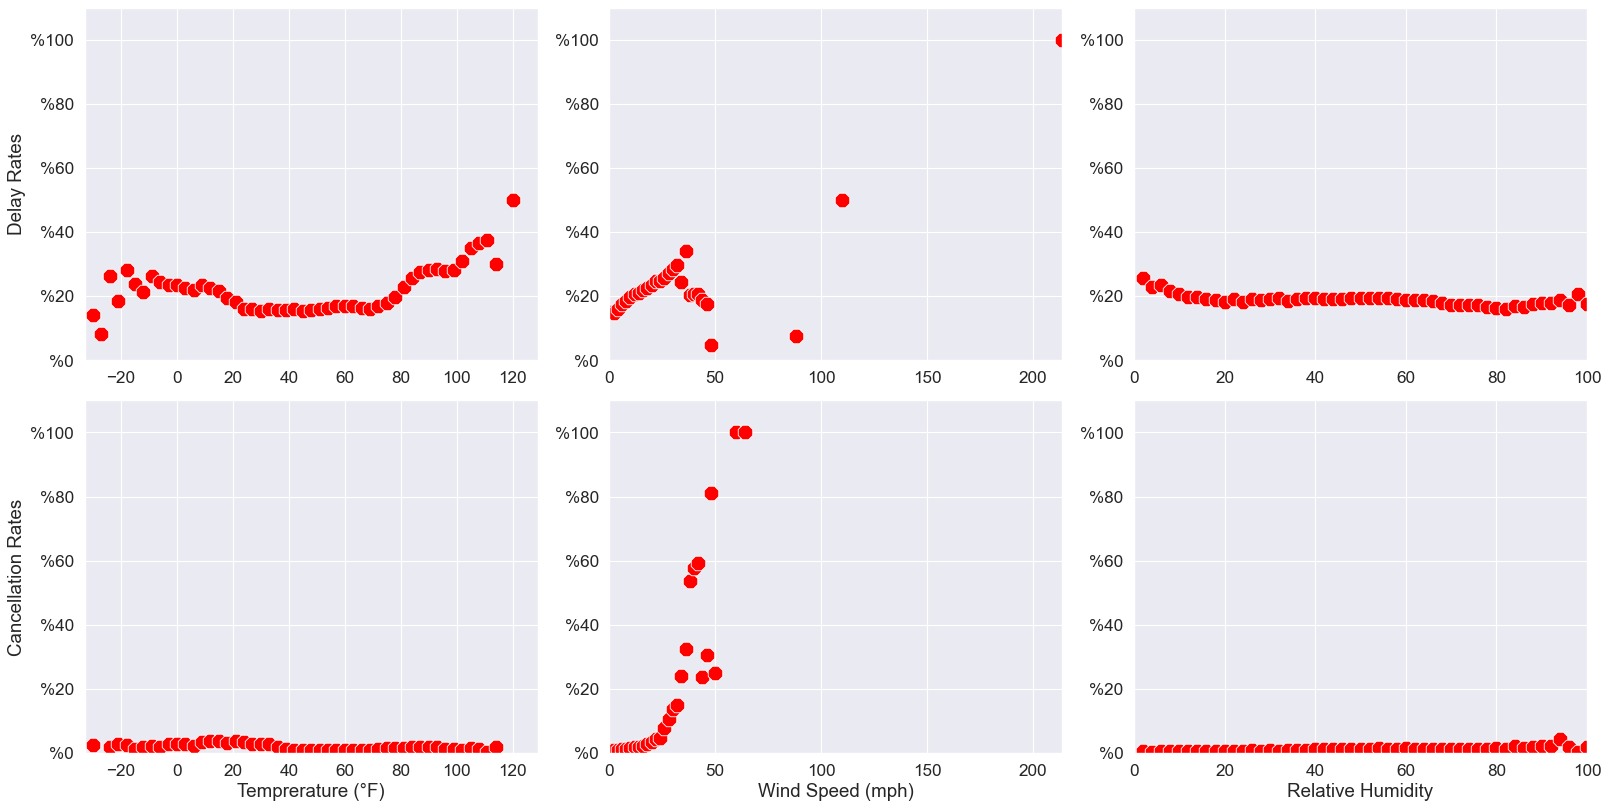

In [11]:
# Big figure
fig = plt.figure(figsize=(20,10), constrained_layout=True, dpi=80)
# Set font size
sns.set(font_scale=1.4)
# Arrange grid size of subplot
grid = plt.GridSpec(2, 3, hspace=0.2, wspace=0.1, figure=fig)
ax_temp1 = plt.subplot(grid[0, 0])
ax_wind1 = plt.subplot(grid[0, 1])
ax_relh1 = plt.subplot(grid[0, 2])
ax_temp2 = plt.subplot(grid[1, 0])
ax_wind2 = plt.subplot(grid[1, 1])
ax_relh2 = plt.subplot(grid[1, 2])
d = {key: np.empty(len(temp)) for key in ['Type', 'Temp', 'Dew', 'RelHum', 'HeatInd', 'Dir', 'WindSp', 'Vsblty']}
temp_df = pd.DataFrame(data=d, index=temp.index)
# On-time
temp_df.loc[:, 'Type'] = 'On-Time'
# Delayed (more than 15 mins)
temp_df.loc[temp.DepDelay >= pd.Timedelta('15 min'), 'Type'] = 'Delayed'
# Cancelled
temp_df.loc[temp.Cncl == 1, 'Type'] = 'Cancelled'
# Diverted
temp_df.loc[temp.Div == 1, 'Type'] = 'Diverted'
# Weather Data
temp_df[['Temp', 'Dew', 'RelHum', 'HeatInd', 'Dir', 'WindSp', 'Vsblty']] = temp.loc[:, ['Temp_O', 'DewPoint_O', 'RelHum_O', 'HeatInd_O', 'Dir_O', 'WindSp_O', 'Visib_O']]
# Group by temperature at the rate of three
t1 = temp_df.groupby(temp_df.Temp // 3 * 3)['Type'].value_counts().unstack()
# Group by wind speed at the rate of three
t2 = temp_df.groupby(temp_df.WindSp // 2 * 2)['Type'].value_counts().unstack()
# Group by wind speed at the rate of three
t3 = temp_df.groupby(temp_df.RelHum // 2 * 2)['Type'].value_counts().unstack()

# Plot
sns.scatterplot(x=t1.index, y=t1.Delayed / t1.sum(axis=1), ci=None, ax=ax_temp1, s=200, marker='8', color='red')
sns.scatterplot(x=t2.index, y=t2.Delayed / t2.sum(axis=1), ci=None, ax=ax_wind1, s=200, marker='8', color='red')
sns.scatterplot(x=t3.index, y=t3.Delayed / t3.sum(axis=1), ci=None, ax=ax_relh1, s=200, marker='8', color='red')

ax_temp1.set_yticks(np.linspace(0, 1, 6, endpoint=True))
ax_temp1.set_xticks([-20, 0, 20, 40, 60, 80, 100, 120])
ax_temp1.set_yticklabels(['%0', '%20', '%40', '%60', '%80', '%100'])
ax_temp1.set_ylim([0, 1.1])
ax_temp1.set_xlim([t1.index.min(), t1.index.max()])
ax_temp1.set_xlabel('')
ax_temp1.set_ylabel('Delay Rates')
ax_wind1.set_yticks(np.linspace(0, 1, 6, endpoint=True))
ax_wind1.set_yticklabels(['%0', '%20', '%40', '%60', '%80', '%100'])
ax_wind1.set_ylim([0, 1.1])
ax_wind1.set_xlim([t2.index.min(), t2.index.max()])
ax_wind1.set_xlabel('')
ax_relh1.set_yticks(np.linspace(0, 1, 6, endpoint=True))
ax_relh1.set_yticklabels(['%0', '%20', '%40', '%60', '%80', '%100'])
ax_relh1.set_ylim([0, 1.1])
ax_relh1.set_xlim([0, 100])
ax_relh1.set_xlabel('')

# Plot
sns.scatterplot(x=t1.index, y=t1.Cancelled / t1.sum(axis=1), ci=None, ax=ax_temp2, s=200, marker='8', color='red')
sns.scatterplot(x=t2.index, y=t2.Cancelled / t2.sum(axis=1), ci=None, ax=ax_wind2, s=200, marker='8', color='red')
sns.scatterplot(x=t3.index, y=t3.Cancelled / t3.sum(axis=1), ci=None, ax=ax_relh2, s=200, marker='8', color='red')

ax_temp2.set_yticks(np.linspace(0, 1, 6, endpoint=True))
ax_temp2.set_xticks([-20, 0, 20, 40, 60, 80, 100, 120])
ax_temp2.set_yticklabels(['%0', '%20', '%40', '%60', '%80', '%100'])
ax_temp2.set_ylim([0, 1.1])
ax_temp2.set_xlim([t1.index.min(), t1.index.max()])
ax_temp2.set_xlabel("Temprerature (\N{DEGREE SIGN}F)")
ax_temp2.set_ylabel('Cancellation Rates')
ax_wind2.set_yticks(np.linspace(0, 1, 6, endpoint=True))
ax_wind2.set_yticklabels(['%0', '%20', '%40', '%60', '%80', '%100'])
ax_wind2.set_ylim([0, 1.1])
ax_wind2.set_xlim([t2.index.min(), t2.index.max()])
ax_wind2.set_xlabel('Wind Speed (mph)')
ax_relh2.set_yticks(np.linspace(0, 1, 6, endpoint=True))
ax_relh2.set_yticklabels(['%0', '%20', '%40', '%60', '%80', '%100'])
ax_relh2.set_ylim([0, 1.1])
ax_relh2.set_xlim([0, 100])
_ = ax_relh2.set_xlabel('Relative Humidity')
# Delete temporary variables
del grid, ax_temp1, ax_wind1, ax_relh1, ax_temp2, ax_wind2, ax_relh2, d, temp_df, t1, t2, t3

#### 2.7. Effect of Wind Speed and Direction on Weather Caused Delays

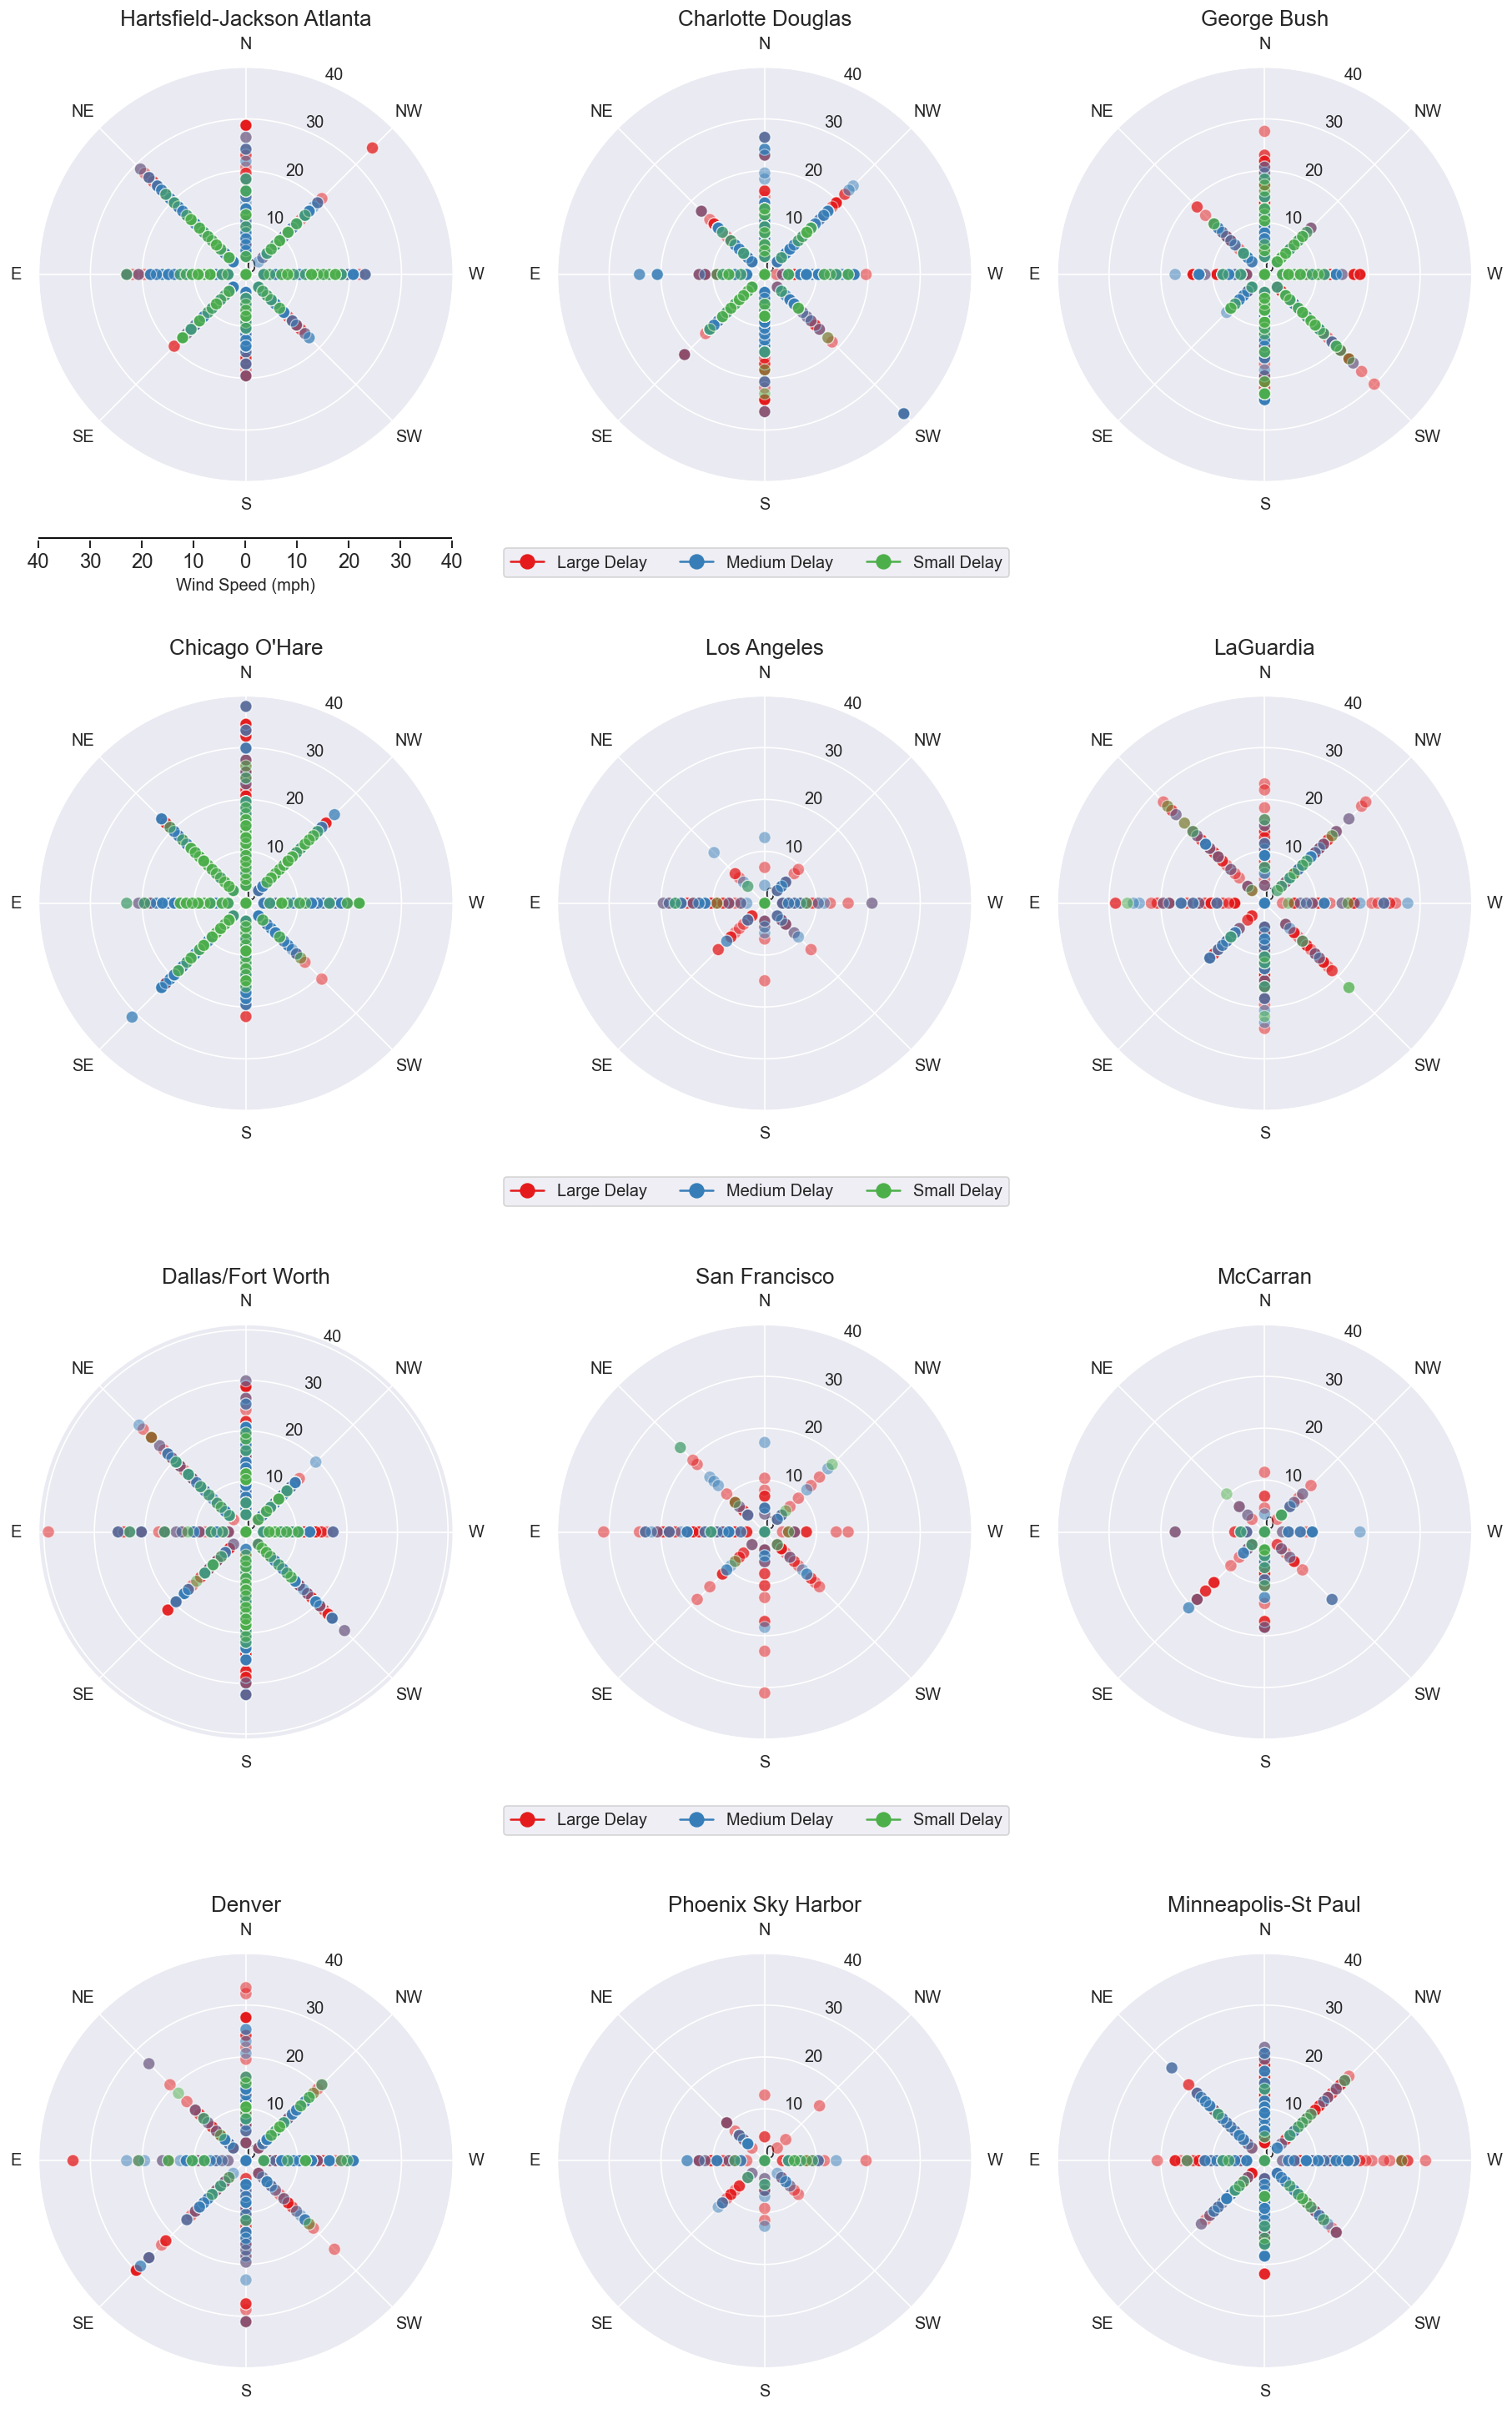

In [12]:
# Top 12 busiest airports
aps = pd.merge(temp.OrgAirID.value_counts().head(12), airport, left_index=True, 
                   right_on='AirID').sort_values('OrgAirID', ascending=False)
# Airport Names
names = [name[:-1] if len(name) > 1 else name for name in aps.Name.str.split(' ')]
names = [' '.join(text) for text in names]
aps.reset_index(inplace=True)
# Subplot rows and columns
nrows = 4
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(15,25), subplot_kw=dict(projection='polar'), 
                        constrained_layout=True, dpi=120)
# Font scaling
sns.set(font_scale=1.3)
# Now, plot in a loop
for idx in range(axs.size):
    tdf = temp[temp.OrgAirID.isin([aps.AirID.loc[idx]])]
    tdf = tdf.copy()
    # Weather dominated delays
    mask = (tdf.WeaDel > tdf.iloc[:, [25, 27, 28, 29]].sum(axis=1))
    tdf = tdf.loc[mask]
    # Assign delay types
    tdf['Type'] = 'OnTime'
    tdf.loc[tdf.DepDelay <= pd.Timedelta('15 min'), 'Type'] = 'Small Delay'
    tdf.loc[(tdf.DepDelay > pd.Timedelta('15 min')) & (tdf.DepDelay <= pd.Timedelta('45 min')), 'Type'] = 'Medium Delay'
    tdf.loc[tdf.DepDelay > pd.Timedelta('45 min'), 'Type'] = 'Large Delay'
    tdf.sort_values('Type', inplace=True)
    # Wind direction 360 = 0
    tdf.Dir_O.replace(360, 0, inplace=True)
    # Wind directions in radian
    theta = round(tdf.Dir_O / 45) * 45 / 180 * np.pi
    # Polar plot
    sc = sns.scatterplot(x=theta, y=tdf.WindSp_O, hue=tdf.Type, ax=axs[idx % 4, idx // 4], 
                         palette='Set1', legend=False, s=75, alpha=0.5)
    # Axis arrangements
    axs[idx % nrows, idx // nrows].set_xlabel('')
    axs[idx % nrows, idx // nrows].set_ylabel('')
    axs[idx % nrows, idx // nrows].set_theta_zero_location('N')
    axs[idx % nrows, idx // nrows].set_theta_direction(-1)
    axs[idx % nrows, idx // nrows].set_thetagrids(range(0,360,45), ('N', 'NW', 'W', 'SW', 'S', 'SE', 'E', 'NE'))
    axs[idx % nrows, idx // nrows].set_rticks(range(0, 40 + 10, 10))
    axs[idx % nrows, idx // nrows].set_title(names[idx], pad=15)
    axs[idx % nrows, idx // nrows].tick_params(labelsize=12)

# Add legend
colors = sns.color_palette('Set1', 3)
lines = [Line2D([0], [0], marker='o', color=c, markerfacecolor=c, markersize=10) for c in colors]
labels = ['Large Delay', 'Medium Delay', 'Small Delay']
axs[0,1].legend(lines, labels,bbox_to_anchor=(.38, -.25, .2, .2), ncol=3, loc='lower center', prop={'size': 12})
axs[1,1].legend(lines, labels,bbox_to_anchor=(.38, -.25, .2, .2), ncol=3, loc='lower center', prop={'size': 12})
axs[2,1].legend(lines, labels,bbox_to_anchor=(.38, -.25, .2, .2), ncol=3, loc='lower center', prop={'size': 12})

# draw the figure to apply constrained_layout
fig.canvas.draw()

# Add scale
rect = axs[0,0].get_position()
bbox = [rect.xmin, rect.ymin-.026, rect.width+.004, rect.height/1.75]
ax = fig.add_axes(bbox)
ax.tick_params(left=False, labelleft=False)
ax.patch.set_visible(False) # hide white background
ax.set_xticks(np.linspace(0, 1, 9))
ax.set_xticklabels(['40', '30', '20', '10', '0', '10', '20', '30','40'])
ax.grid(False)
sns.despine(ax=ax, top=True, right=True, left=True)
ax.xaxis.set_ticks_position('bottom')
ax.axhline(y=0, c='black', ls='-', lw=3.5)
_ = ax.set_xlabel('Wind Speed (mph)', fontsize=12)

# Delete temporary variables
del aps, names, nrows, ncols, tdf, mask, theta, sc, colors, lines, axs, rect, bbox, ax

#### 2.8. Effect of Wind Speed and Direction on Weather Caused Cancellations

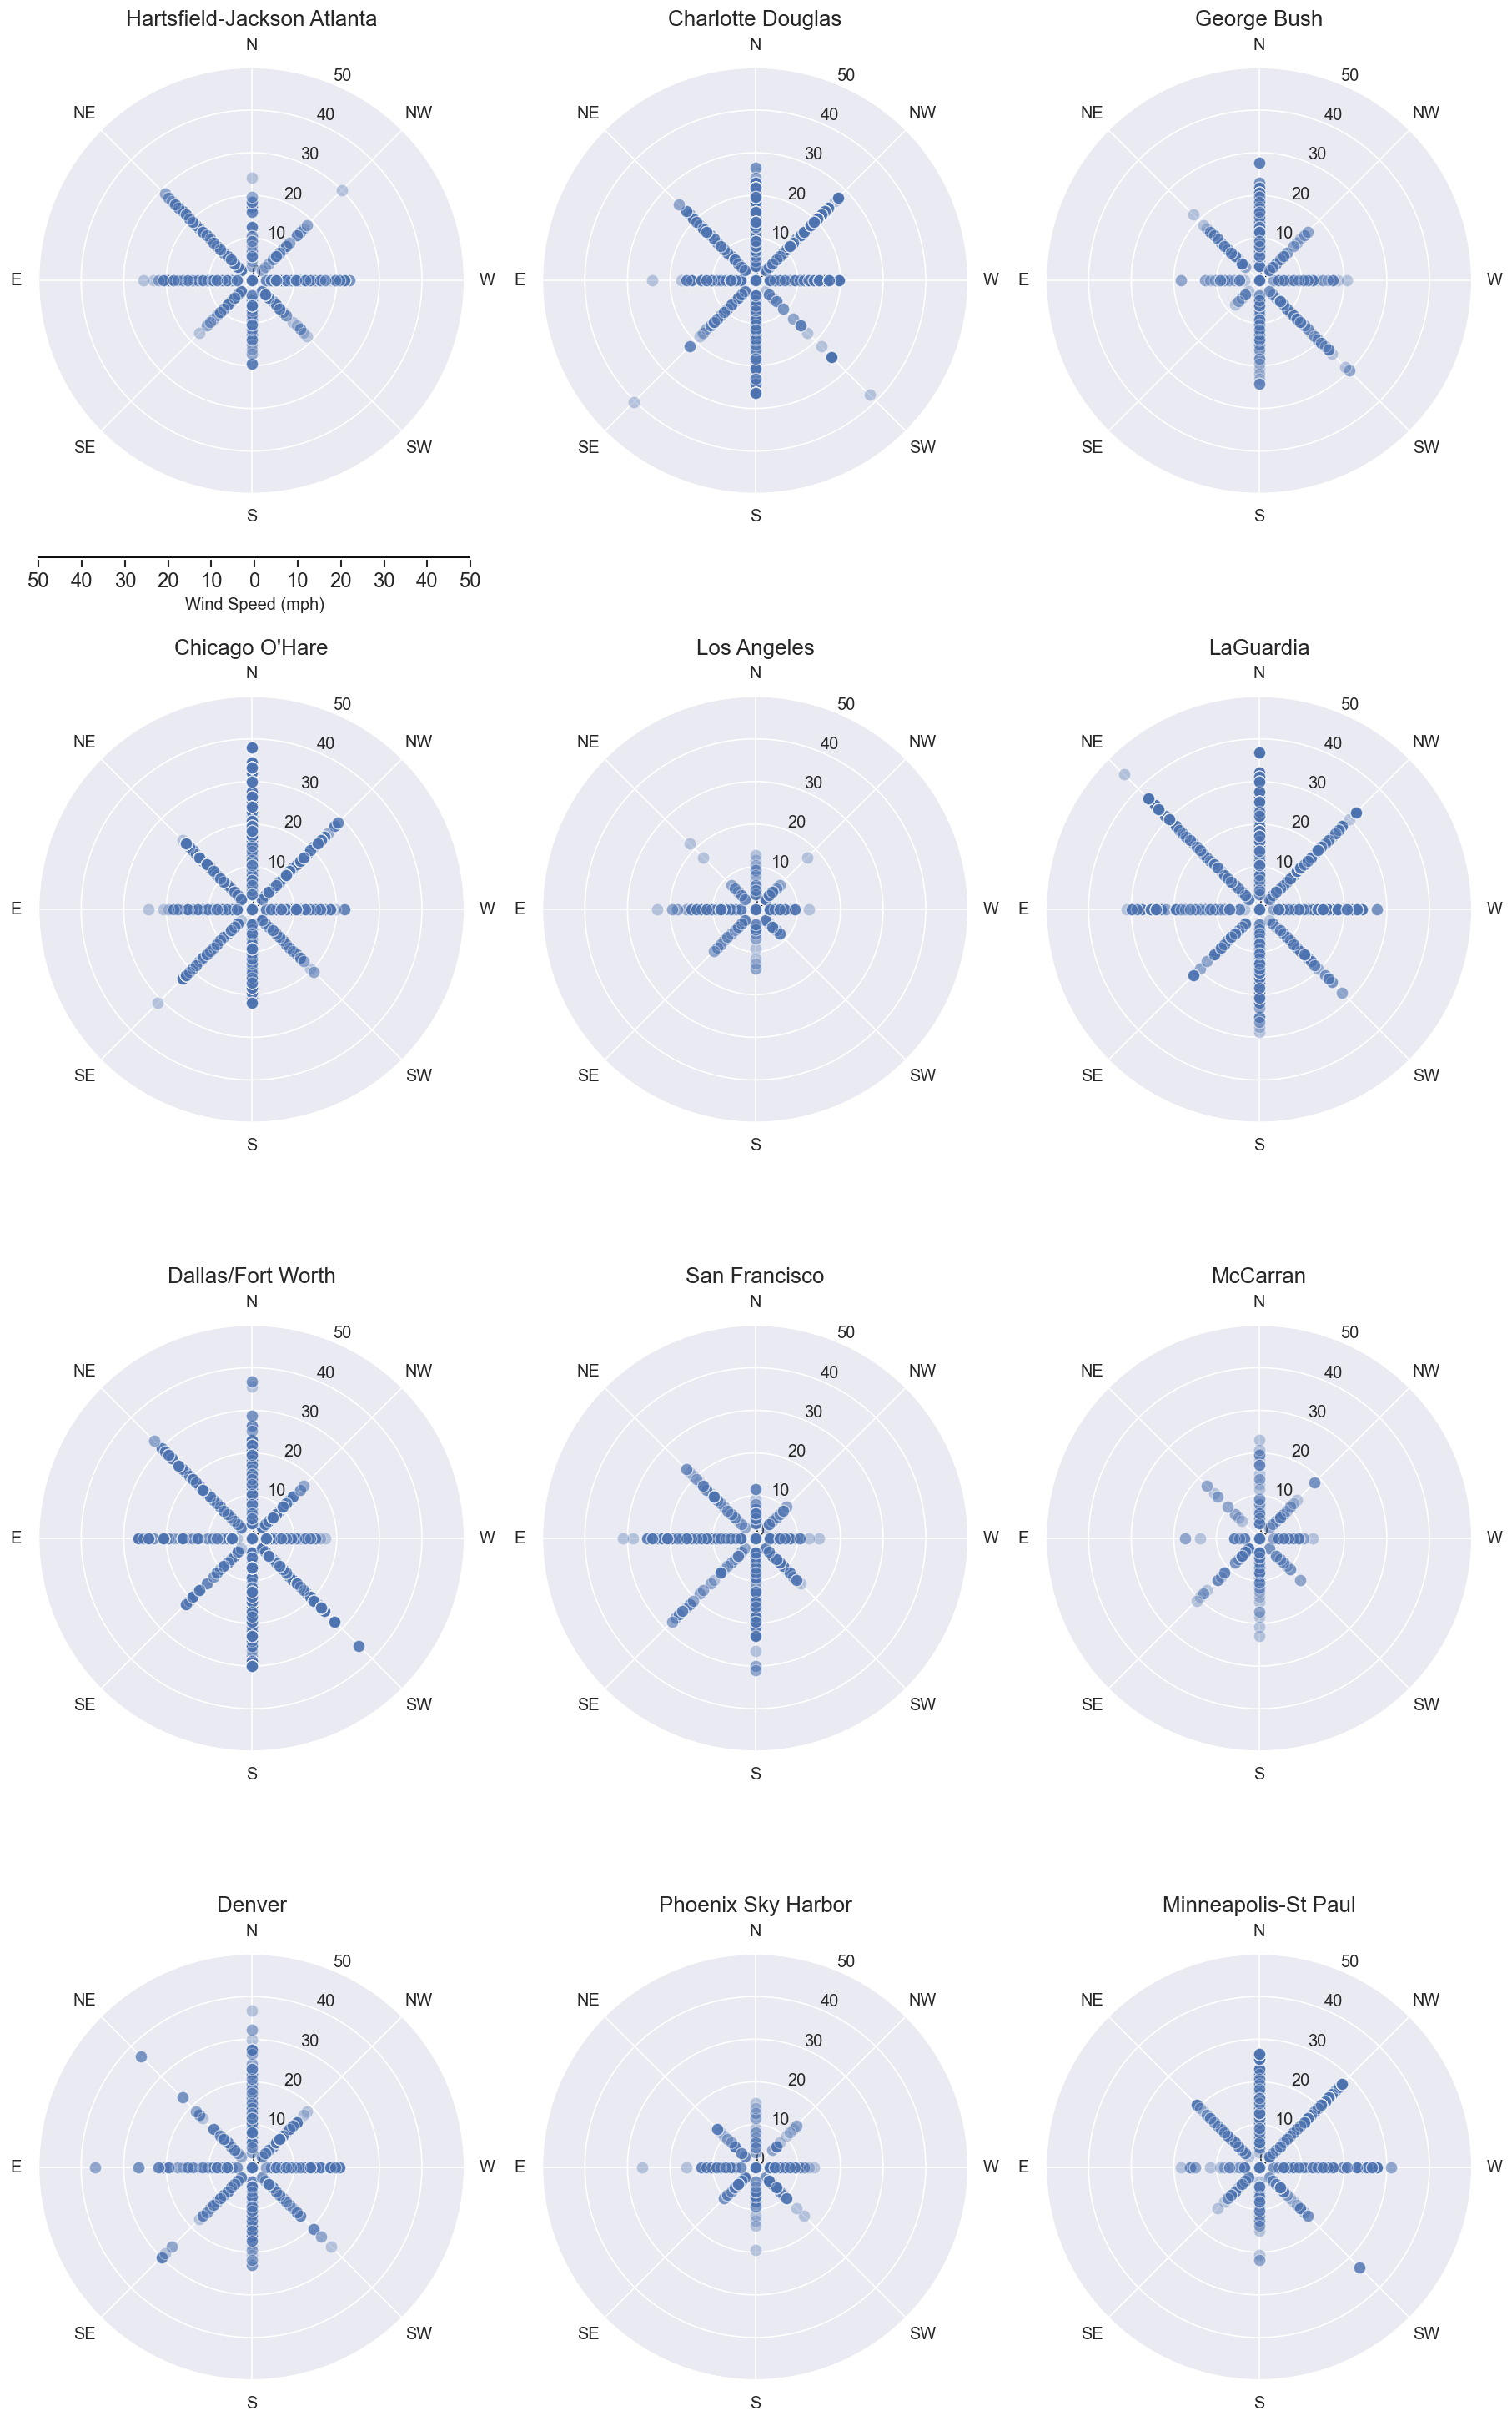

In [13]:
# Top 12 busiest airports
aps = pd.merge(temp.OrgAirID.value_counts().head(12), airport, left_index=True, 
                   right_on='AirID').sort_values('OrgAirID', ascending=False)
# Airport Names
names = [name[:-1] if len(name) > 1 else name for name in aps.Name.str.split(' ')]
names = [' '.join(text) for text in names]
aps.reset_index(inplace=True)
# Subplot rows and columns
nrows = 4
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(15,25), subplot_kw=dict(projection='polar'), 
                        constrained_layout=True, dpi=120)
# Font scaling
sns.set(font_scale=1.3)
# Now, plot in a loop
for idx in range(axs.size):
    tdf = temp[temp.OrgAirID.isin([aps.AirID.loc[idx]])]
    tdf = tdf.copy()
    # Weather dominated delays
    mask = (tdf.CnclCd == 2)
    tdf = tdf.loc[mask]
    # Wind direction 360 = 0
    tdf.Dir_O.replace(360, 0, inplace=True)
    # Wind directions in radian
    theta = round(tdf.Dir_O / 45) * 45 / 180 * np.pi
    # Polar plot
    sc = sns.scatterplot(x=theta, y=tdf.WindSp_O, ax=axs[idx % nrows, idx // nrows], 
                         palette='Set1', legend=False, s=75, alpha=0.35)
    # Axis arrangements
    axs[idx % nrows, idx // nrows].set_xlabel('')
    axs[idx % nrows, idx // nrows].set_ylabel('')
    axs[idx % nrows, idx // nrows].set_theta_zero_location('N')
    axs[idx % nrows, idx // nrows].set_theta_direction(-1)
    axs[idx % nrows, idx // nrows].set_thetagrids(range(0,360,45), ('N', 'NW', 'W', 'SW', 'S', 'SE', 'E', 'NE'))
    axs[idx % nrows, idx // nrows].set_rticks(range(0, 50 + 10, 10))
    axs[idx % nrows, idx // nrows].set_title(names[idx], pad=15)
    axs[idx % nrows, idx // nrows].tick_params(labelsize=12)

# draw the figure to apply constrained_layout
fig.canvas.draw()

# Add scale
rect = axs[0,0].get_position()
bbox = [rect.xmin, rect.ymin-.026, rect.width+.004, rect.height/1.75]
ax = fig.add_axes(bbox)
ax.tick_params(left=False, labelleft=False)
ax.patch.set_visible(False) # hide white background
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xticklabels(['50', '40', '30', '20', '10', '0', '10', '20', '30','40', '50'])
ax.grid(False)
sns.despine(ax=ax, top=True, right=True, left=True)
ax.xaxis.set_ticks_position('bottom')
ax.axhline(y=0, c='black', ls='-', lw=3.5)
_ = ax.set_xlabel('Wind Speed (mph)', fontsize=12)

# Delete temporary variables
del aps, names, nrows, ncols, tdf, mask, theta, sc, axs, rect, bbox, ax

#### 2.9. Origin-Destionation Pair Average Amount of Delay

In [14]:
# Top 20 airports
top20 = temp.OrgAirID.value_counts().head(20).index
# Airport names
aps = airport.loc[airport.AirID.isin(top20)]
names = [name[:-1] if len(name) > 1 else name for name in aps.Name.str.split(' ')]
names = [' '.join(text) for text in names]
temp_df = temp.loc[temp.OrgAirID.isin(top20)]
temp_df = temp_df.loc[temp_df.DestAirID.isin(top20)]
temp_df = temp_df.groupby(['OrgAirID', 'DestAirID'])['DepDelay'].apply(lambda x: np.mean(x)).to_frame()
temp_df.reset_index(inplace=True)
temp_df = temp_df.pivot(index='OrgAirID', columns='DestAirID', values='DepDelay')
temp_df = temp_df.astype('timedelta64[s]') / 60
# Heat map
fig = px.imshow(temp_df.round(2), labels=dict(x='Destination Airport', y='Origin Airport', color='Departure Delay (min)'), 
                x=names, y=names, aspect='auto', color_continuous_scale='YlGnBu')
fig.update_layout(width=950, height=700, title='', xaxis_title='', coloraxis_showscale=False,
                  yaxis_title='', font=dict(family="sans-serif", size=12, color="#000000"))
fig.update_xaxes(side="top", tickangle=315, showgrid=True)
fig.update_yaxes(tickangle=-0.115, showgrid=True)
fig.show()
# Delete temporary variables
del top20, aps, names, temp_df, fig

#### 2.9. Late Aircraft Delays

100% (5719 of 5719) |####################| Elapsed Time: 0:04:19 ETA:  00:00:00

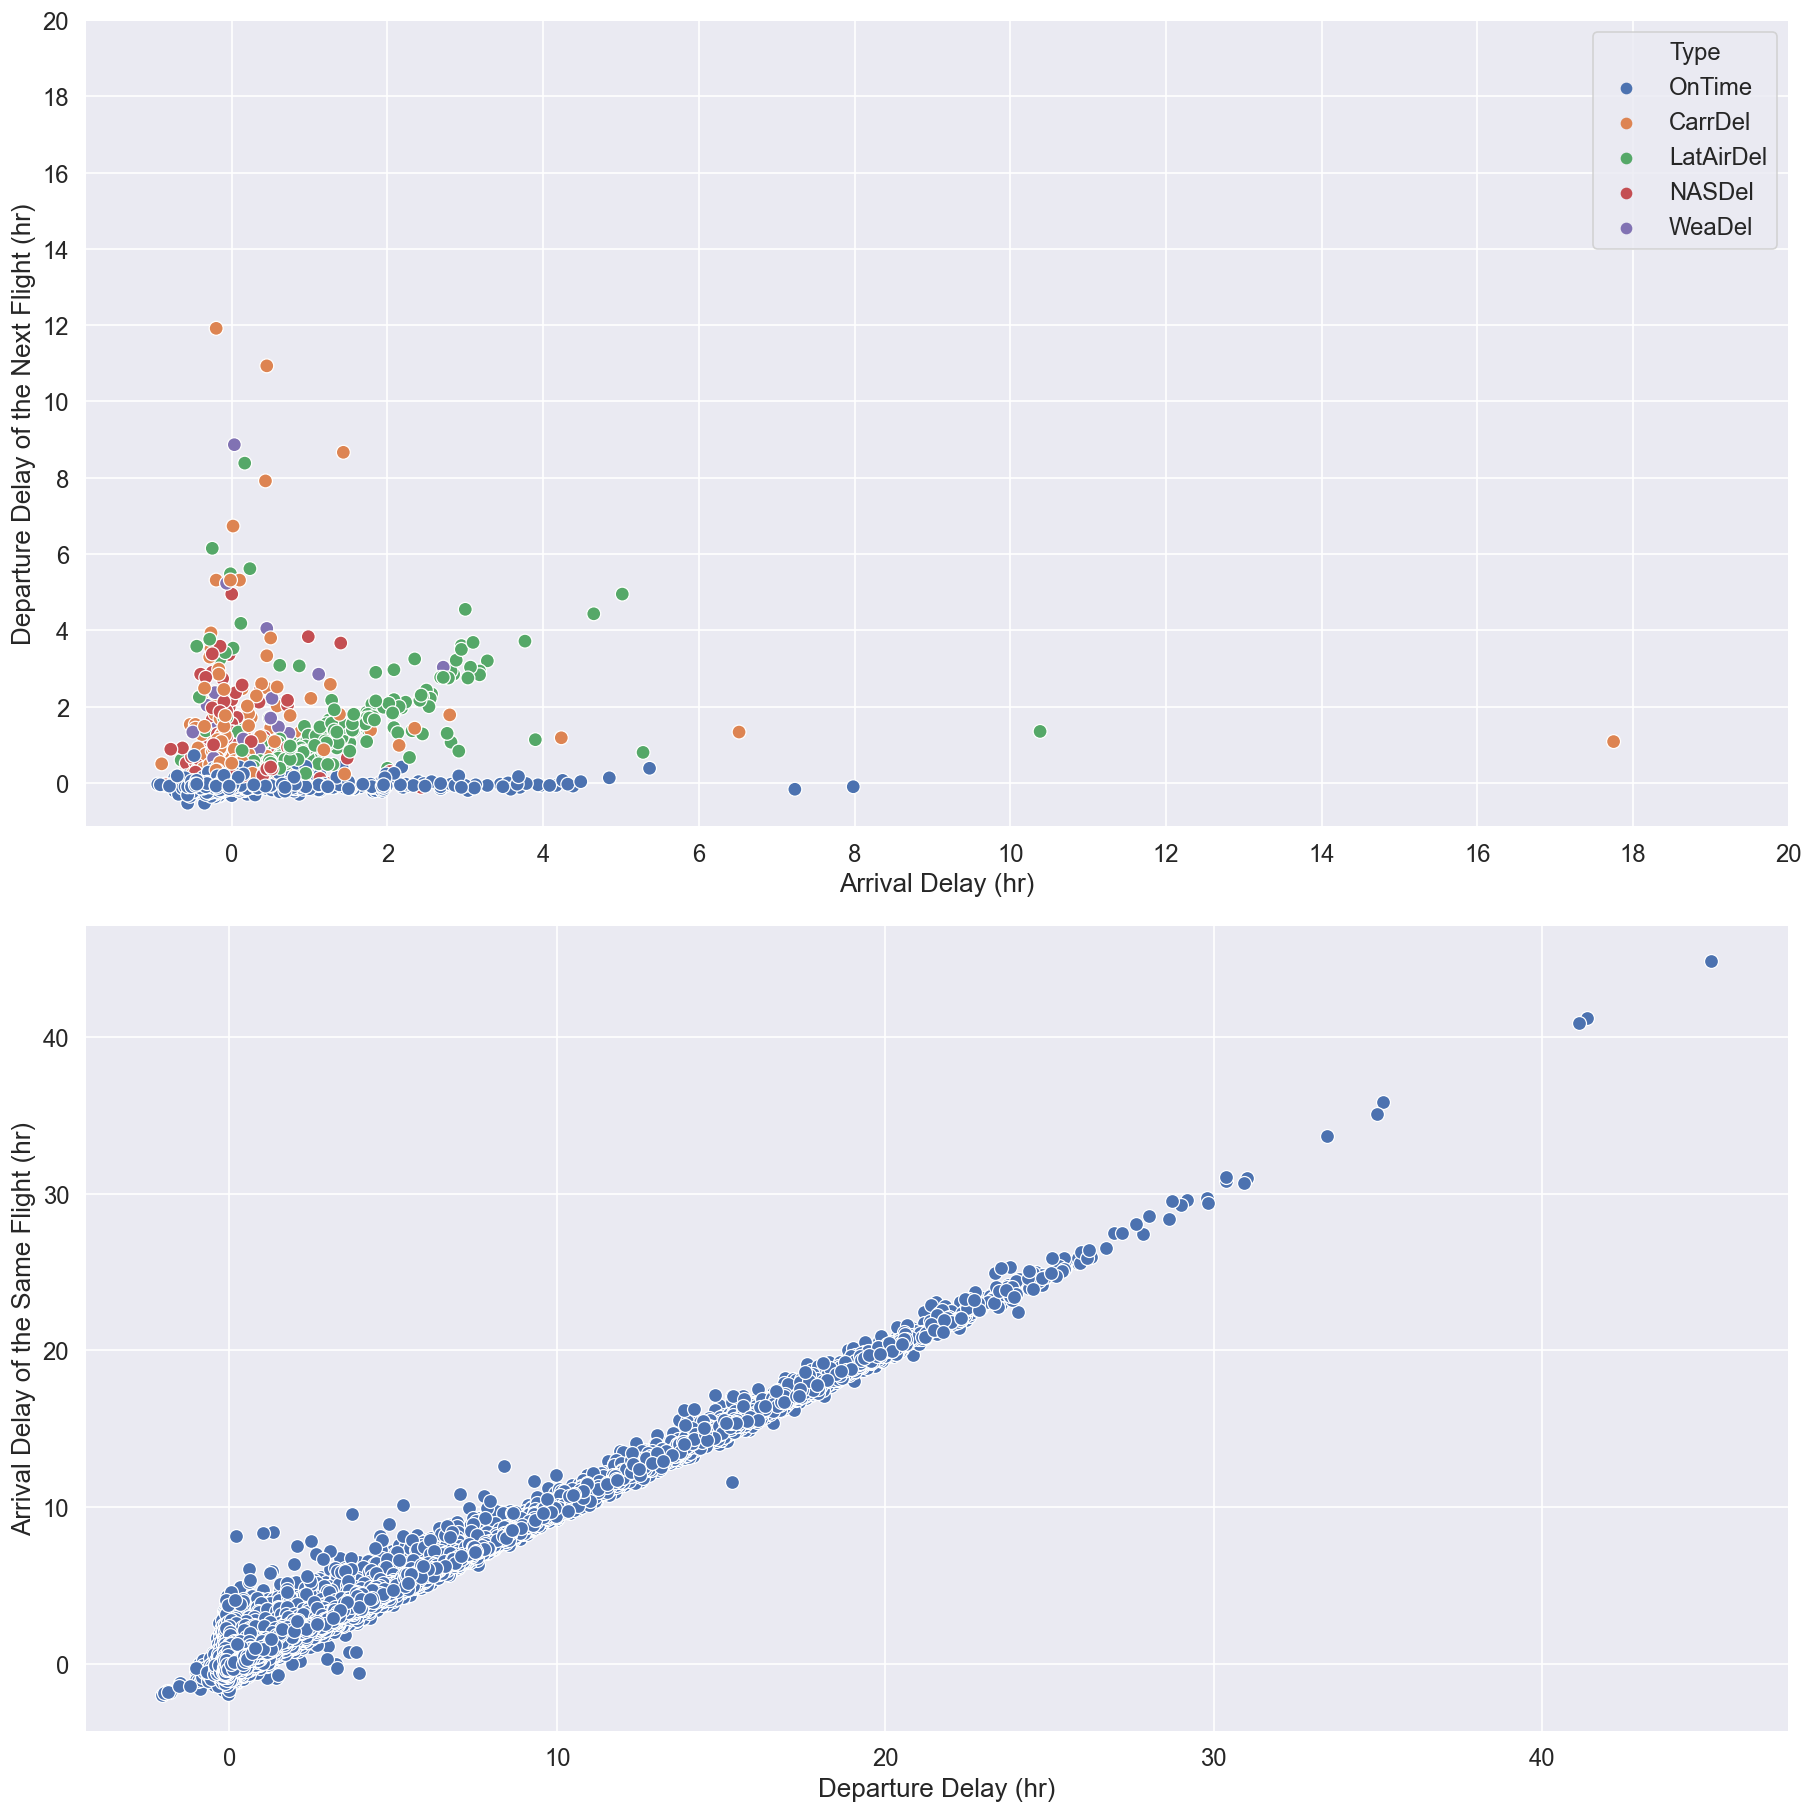

In [15]:
flights = flights.sort_values('DepTime')
mask = (flights.Cncl == 0) & (flights.Div == 0)
temp_df = flights.loc[mask, ['TailNum', 'DepDelay', 'ArrDelay', 'ScDepTime', 'ArrTime']]
temp_df['Type'] = np.where(flights.loc[temp_df.index].iloc[:, 25:30].sum(axis=1) != 0, flights.loc[temp_df.index].iloc[:, 25:30].idxmax(axis=1), 'OnTime')
tail_nums = temp_df.TailNum.drop_duplicates()
tail_nums = tail_nums.reset_index(drop=True)
# Create empty data frame
tdf = pd.DataFrame(data={}, columns=['TimeDiff', 'ArrDelay', 'DepDelay', 'Type'])
bar = progressbar.ProgressBar(max_value=len(tail_nums))
for key, val in tail_nums.items():
    x = temp_df[temp_df.TailNum == val].sort_values('ScDepTime')
    a = x.iloc[1:, 1].reset_index(drop=True).astype('timedelta64[m]') # Departure delays
    b = x.iloc[:-1, 2].reset_index(drop=True).astype('timedelta64[m]') # Arrival delays
    c = (x.iloc[1:, 3].reset_index(drop=True) - x.iloc[:-1, 4].reset_index(drop=True)).rename('TimeDiff').astype('timedelta64[m]')
    d = x.iloc[1:, 5].reset_index(drop=True)
    tdf = tdf.append(pd.concat([c, b, a, d], axis=1), ignore_index=True)
    bar.update(key+1)
fig, axs = plt.subplots(2, 1, figsize=(15,15), constrained_layout=True, dpi=120)
sns.scatterplot(x=tdf.ArrDelay/60, y=tdf.DepDelay/60, ci=None, data=tdf.sample(5000), hue='Type', ax=axs[0], s=70)
sns.scatterplot(x=temp_df.DepDelay.astype('timedelta64[m]')/60, y=temp_df.ArrDelay.astype('timedelta64[m]')/60, ci=None, ax=axs[1], s=70)
axs[0].set_xlabel('Arrival Delay (hr)')
axs[0].set_ylabel('Departure Delay of the Next Flight (hr)')
axs[0].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
axs[0].set_yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
axs[1].set_xlabel('Departure Delay (hr)')
_ = axs[1].set_ylabel('Arrival Delay of the Same Flight (hr)')